## Library

In [37]:
import math
import random
import numpy as np
from copy import copy
from scipy import stats
from pprint import pprint
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

exec(open('library.py').read())
print('Loaded 2')

STATES = ['boring', 'xrisk_unaligned_tai', 'aligned_tai', 'xrisk_unknown_unknown', 'xrisk_tai_misuse',
          'xrisk_nanotech', 'xrisk_nukes_war', 'xrisk_nukes_accident', 'xrisk_bio_accident', 'xrisk_bio_war',
          'xrisk_bio_nonstate']

def print_states(collector):
    c = Counter([r[0]['category'] for r in collector])
    c = dict([(k, round(v / RUNS * 100, 2)) for k, v in c.items()])
    for k in c.keys():
        if k not in STATES:
            raise ValueError('State {} not in `STATES`'.format(k))
    for state in STATES:
        if not c.get(state):
            c[state] = 0.0
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    return c

print('Loaded 3')

Loaded
Loaded 2
Loaded 3


## Variables (customize these)

In [38]:
# Customize these!!!

# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 1000)
CURRENT_YEAR = 2022                               # What year to start the run on? (default: 2022)
MAX_YEAR = 2222                                   # What year to end the run on? (default: 2100)
CREDIBLE_INTERVAL = 0.9                           # CIs are 90% CIs


# This is a PDF for when TAI will be available to be developed. Look to `When TAI?` notebook to generate this.
# TODO: Update to latest
tai_pdf = [0.0038, 0.0024, 0.0052, 0.0074, 0.0088, 0.0088, 0.0126, 0.0144,
       0.0142, 0.0184, 0.0162, 0.0208, 0.0162, 0.0198, 0.0176, 0.0218,
       0.0196, 0.0216, 0.0228, 0.0206, 0.0182, 0.0156, 0.0168, 0.0168,
       0.0182, 0.0128, 0.0166, 0.0122, 0.0134, 0.014 , 0.0122, 0.0112,
       0.0118, 0.0102, 0.0112, 0.0102, 0.0106, 0.0132, 0.009 , 0.0088,
       0.0074, 0.012 , 0.008 , 0.0076, 0.0046, 0.006 , 0.0072, 0.0078,
       0.008 , 0.0072, 0.006 , 0.0064, 0.0052, 0.0036, 0.0056, 0.0068,
       0.0062, 0.0062, 0.0056, 0.0054, 0.0038, 0.003 , 0.0034, 0.0032,
       0.0064, 0.0044, 0.0032, 0.0032, 0.0024, 0.0036, 0.0018, 0.0038,
       0.0044, 0.0022, 0.0028, 0.0024, 0.0026, 0.0012, 0.0024, 0.0024,
       0.0022, 0.0018, 0.0024, 0.0026, 0.0014, 0.0024, 0.0022, 0.0032,
       0.0024, 0.0012, 0.001 , 0.0014, 0.0004, 0.0016, 0.0012, 0.001 ,
       0.0012, 0.0012, 0.0018, 0.0018, 0.0014, 0.002 , 0.0006, 0.0014,
       0.001 , 0.0016, 0.0018, 0.001 , 0.0012, 0.001 , 0.0014, 0.0008,
       0.0014, 0.0008, 0.0014, 0.0014, 0.0012, 0.0006, 0.0008, 0.0014,
       0.001 , 0.0008, 0.0012, 0.0008, 0.0014, 0.0006, 0.0006, 0.0004,
       0.0008, 0.0008, 0.001 , 0.0008, 0.001 , 0.0006, 0.0008, 0.0006,
       0.0004, 0.001 , 0.0002, 0.001 , 0.0006, 0.0004, 0.001 , 0.0012,
       0.0008, 0.0004, 0.001 , 0.0004, 0.0006, 0.0008, 0.0008, 0.0012,
       0.0004, 0.0008, 0.001 , 0.0002, 0.001 , 0.0008, 0.0004, 0.0004,
       0.0002, 0.0004, 0.0012, 0.0006, 0.0008, 0.0004, 0.0006, 0.0008,
       0.0002, 0.0002, 0.0006, 0.0006, 0.0006, 0.0008, 0.0002, 0.0006,
       0.0002, 0.0002, 0.0002, 0.0004, 0.0002, 0.0002, 0.0006, 0.001 ,
       0.0002, 0.0012, 0.0004, 0.0008, 0.0006, 0.0008, 0.0006, 0.0004,
       0.0002, 0.0002, 0.0004, 0.0004, 0.0006, 0.0002, 0.0002, 0]
tai_pdf = np.array(tai_pdf)


# Make the chance TAI alignment is solved be a function of year
# This version starts at 30% and rises to 75% over time
# 30% can be best interpreted here as the likelihood that AI is "safe by default"
def p_alignment_solved(war, year, first_attempt=True):
    if first_attempt:
        p = min(0.25 + 0.25*(year/100), 0.75)
    else:
        p = min(0.25 + 0.35*(year/100), 0.85)
    if war:
        p = p * (2/3)
    return p

# Conditoinal on making TAI, will it be agentic?
p_make_agent_tai = 0.9

# Conditional on making an unaligned agentic TAI, will it produce an xrisk?
p_unaligned_tai_is_xrisk = 0.8 * 0.3 * 0.98

# Relative to AI xrisk, how often will "merely" 10% of people die?
ratio_xrisk_catastropic_risk = 1.1

# Conditional on having TAI available, will it be intentionally misused to create a singleton?
def p_tai_intentional_misuse(war):
    return 0.3 * 0.3 if war else 0.05 * 0.3

p_tai_xrisk_is_extinction = 0.2

# What is the chance in a given year there will be a great power war?
def p_great_power_war(year):
    if year < 2025:
        return 0.006
    elif year < 2030:
        return 0.006 + 0.3*0.01*0.2
    elif year < 2040:
        return 0.006 + 0.002 + 0.05*0.01*0.2
    else:
        return (0.006 + 0.05*0.05*0.2) * (0.99 ** year)

# Conditional on a great power war starting, how long will it last?
war_length = lognorm(2, 50) # 90% CI

# What is the chance in a given year there will be a "nuclear accident"?
def p_nuclear_accident(war, year):
    p = 0.06 if war else 0.02
    p = p * (0.997 ** year)
    return p
# TODO: Graph

# Conditional on a nuclear accident, what is the chance it escalates into an "exchange"?
def p_nuclear_accident_becomes_exchange(war):
    return 0.2 if war else 0.05

# Conditional on a nuclear exchange, what is the chance it escalates into a xrisk?
def p_xrisk_from_nuclear_exchange(war):
    p = 0.8 if war else 0.6
    p = p * 0.2 * 0.2
    return p
    # TODO: maybe also change arsenal size over time?

# What is the chance of an accidental biorisk (e.g., lab leak) causing 1%+ population death?
def p_natural_bio(year):
    return 0.001 * (0.99 ** year)
    
# What is the chance of an accidental biorisk (e.g., lab leak) causing 1%+ population death?
def p_accidental_bio(war):
    return 0.005 if war else 0.001

# Conditional on a accidental biorisk, what is the chance it becomes a xrisk?
def p_xrisk_from_accidental_bio(year):
    p = 0.2 * 0.2 * 0.2
    p = p * (0.99 ** year)
    return p
# TODO: Graph
    
# Conditional on a great power war, what is the chance it goes nuclear in any given year?
p_nuclear_war_given_war = 0.05

# Conditional on a great power war, what is the chance it results in a bioweapon?
p_biowar_given_war = 0.02

# What is the chance of a non-state actor creating a biorisk?
p_nonstate_bio = 0.001

# Conditional on a bioweapon, what is the chance it becomes a xrisk?
def p_xrisk_from_intentional_bio(year):
    p = 0.2 * 0.2
    p = p * (0.995 ** year)
    return p
# TODO: Graph

# Wha is the chance in a given year that nanotech will be developed?
def p_nanotech_possible(year):
    return 0.0001 / (0.956 ** year) # TODO: This goes over 1
# TODO: Graph

# Conditional on developing nanotech, what is the chance nanotech results in an xrisk?
p_nanotech_is_xrisk = 0.1

# What is the chance in any given year that an unknown unknown xrisk occurs?
def p_unknown_unknown_xrisk(year):
    return 0.0001 / (0.99 ** year) # TODO: This goes over 1
# TODO: Graph
    

# ------------- Ignore below here ------------
years = list(range(CURRENT_YEAR, MAX_YEAR))
print('Loaded')

Loaded


## TAI Timelines

Text(0, 0.5, 'chance of TAI IN year')

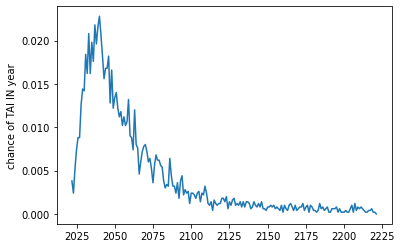

In [39]:
plt.plot(years, tai_pdf)
plt.ylabel('chance of TAI IN year')


Text(0, 0.5, 'chance of TAI BY year')

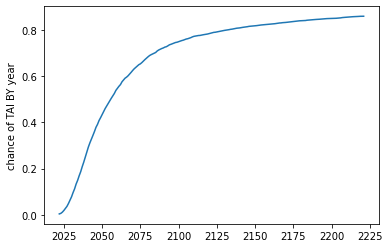

In [40]:
tai_cdf = np.cumsum(tai_pdf)
plt.plot(years, tai_cdf)
plt.ylabel('chance of TAI BY year')


## Chance of Solving Alignment by Year (Conditional on TAI in that year, no war, first attempt)

Text(0, 0.5, 'chance of solving alignment if TAI in year')

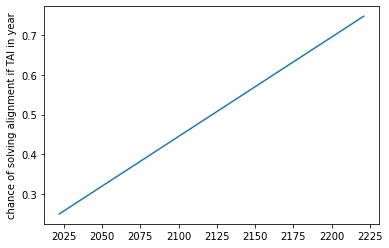

In [41]:
alignment_p = np.array([p_alignment_solved(war=False, year=y - CURRENT_YEAR, first_attempt=True) for y in years])
plt.plot(years, alignment_p)
plt.ylabel('chance of solving alignment if TAI in year')


In [42]:
for y in years:
    print('Year: {} - chance of solving TAI alignment {}%'.format(y,
                                                                  np.round(alignment_p[y - CURRENT_YEAR] * 100, 0)))

Year: 2022 - chance of solving TAI alignment 25.0%
Year: 2023 - chance of solving TAI alignment 25.0%
Year: 2024 - chance of solving TAI alignment 26.0%
Year: 2025 - chance of solving TAI alignment 26.0%
Year: 2026 - chance of solving TAI alignment 26.0%
Year: 2027 - chance of solving TAI alignment 26.0%
Year: 2028 - chance of solving TAI alignment 26.0%
Year: 2029 - chance of solving TAI alignment 27.0%
Year: 2030 - chance of solving TAI alignment 27.0%
Year: 2031 - chance of solving TAI alignment 27.0%
Year: 2032 - chance of solving TAI alignment 28.0%
Year: 2033 - chance of solving TAI alignment 28.0%
Year: 2034 - chance of solving TAI alignment 28.0%
Year: 2035 - chance of solving TAI alignment 28.0%
Year: 2036 - chance of solving TAI alignment 29.0%
Year: 2037 - chance of solving TAI alignment 29.0%
Year: 2038 - chance of solving TAI alignment 29.0%
Year: 2039 - chance of solving TAI alignment 29.0%
Year: 2040 - chance of solving TAI alignment 30.0%
Year: 2041 - chance of solving 

## Great Power War

Text(0, 0.5, 'chance of great power war IN year')

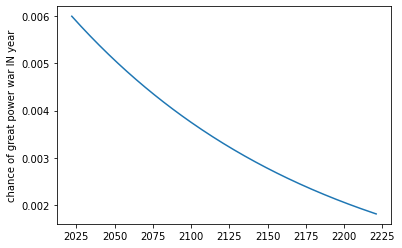

In [43]:
war_pdf = np.array([p_great_power_war(y - CURRENT_YEAR) for y in years])
war_pdf = [war_pdf[0] if x == 0 else war_pdf[x] * np.prod(1 - war_pdf[:x]) for x in range(MAX_YEAR - CURRENT_YEAR)]
plt.plot(years, war_pdf)
plt.ylabel('chance of great power war IN year')


Text(0, 0.5, 'chance of great power war BY year')

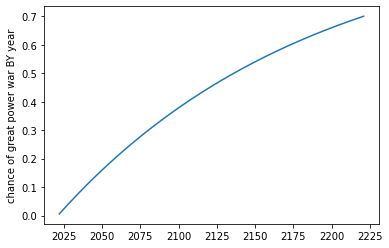

In [44]:
war_cdf = np.cumsum(war_pdf)
plt.plot(years, war_cdf)
plt.ylabel('chance of great power war BY year')


In [45]:
for y in years:
    print('Year: {} - chance of war IN year {}%, BY year {}%'.format(y,
                                                                     np.round(war_pdf[y - CURRENT_YEAR] * 100, 1),
                                                                     np.round(war_cdf[y - CURRENT_YEAR] * 100, 1)))

Year: 2022 - chance of war IN year 0.6%, BY year 0.6%
Year: 2023 - chance of war IN year 0.6%, BY year 1.2%
Year: 2024 - chance of war IN year 0.6%, BY year 1.8%
Year: 2025 - chance of war IN year 0.6%, BY year 2.4%
Year: 2026 - chance of war IN year 0.6%, BY year 3.0%
Year: 2027 - chance of war IN year 0.6%, BY year 3.5%
Year: 2028 - chance of war IN year 0.6%, BY year 4.1%
Year: 2029 - chance of war IN year 0.6%, BY year 4.7%
Year: 2030 - chance of war IN year 0.6%, BY year 5.3%
Year: 2031 - chance of war IN year 0.6%, BY year 5.8%
Year: 2032 - chance of war IN year 0.6%, BY year 6.4%
Year: 2033 - chance of war IN year 0.6%, BY year 7.0%
Year: 2034 - chance of war IN year 0.6%, BY year 7.5%
Year: 2035 - chance of war IN year 0.6%, BY year 8.1%
Year: 2036 - chance of war IN year 0.6%, BY year 8.6%
Year: 2037 - chance of war IN year 0.5%, BY year 9.2%
Year: 2038 - chance of war IN year 0.5%, BY year 9.7%
Year: 2039 - chance of war IN year 0.5%, BY year 10.3%
Year: 2040 - chance of war 

In [46]:
war_length_p = get_percentiles([sample(war_length, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
war_length_p

{95: 2.061185732786259,
 90: 3.027223393120012,
 80: 4.5047243243020025,
 70: 6.1574694278683015,
 60: 8.120676387154766,
 50: 10.207974146499115,
 40: 13.32468183848577,
 30: 17.513629319963254,
 20: 22.393754424647547,
 10: 33.67125491685995,
 5: 47.27431387240242}

## Run Model

In [47]:
def p_tai_occurs_in(year):
    if year < 0:
        raise ValueError
    elif year == 0:
        return tai_pdf[0]
    else:
        return tai_pdf[year] / (1 - sum(tai_pdf[y] for y in range(year)))
    

collectors = {}
collect_years = [2022, 2024, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100, 2150, 2200]
for y in collect_years:
    collectors[y] = []

results = []
print('Loaded')
print('-')

for r in range(RUNS):
    print('## RUN {}/{} ##'.format(r + 1, RUNS))
    terminate = False; terminate_y = None
    state = {'category': 'boring', 'tai': False, 'tai_type': None, 'nano': False, 'war': False,
             'engineered_pathogen': False, 'natural_pathogen': False}
    
    for y in years:
        if not terminate:

            ## TAI Scenarios
            if not terminate and (event_occurs(p_tai_occurs_in(y - CURRENT_YEAR)) or state['tai']):
                # TODO: Slow vs. fast takeoff
                if (event_occurs(p_make_agent_tai) or state['tai_type'] == 'agent') and state['tai_type'] != 'tool':
                    # TODO: Do we want to re-roll the possibility of making agentic TAI in future years?
                    if event_occurs(p_alignment_solved(state['war'], y - CURRENT_YEAR, first_attempt=state['tai'])):
                        print('{}: ...Acheived aligned TAI, happy future! :D'.format(y))
                        state['category'] = 'aligned_tai'; state['tai'] = True; state['tai_type'] = 'agent'
                        terminate = True; terminate_y = y
                        # TODO: Does aligned TAI make all other xrisks impossible? We currently assume it does
                            # TODO: Maybe introduce takeoff delay before other xrisks become impossible?
                    elif event_occurs(p_unaligned_tai_is_xrisk):
                        print('{}: ...XRISK from unaligned TAI :('.format(y))
                        state['category'] = 'xrisk_unaligned_tai'; state['tai'] = True; state['tai_type'] = 'agent'
                        terminate = True; terminate_y = y
                    elif event_occurs(p_tai_intentional_misuse(state['war'])):
                        print('{}: ...XRISK from intentional misuse of TAI :('.format(y))
                        state['category'] = 'xrisk_tai_misuse'; state['tai'] = True; state['tai_type'] = 'agent'
                        terminate = True; terminate_y = y
                    else:
                        print('{}: ...Agent TAI made but no x-risk or alignment yet?'.format(y))
                        state['tai'] = True; state['tai_type'] = 'agent'
                        # TODO: These scenarios require more analysis
                elif not state['tai']:
                    print('{}: ...Tool TAI made'.format(y))
                    state['tai'] = True; state['tai_type'] = 'tool'
                    # TODO: Does tool AI help mitigate xrisk?
            # TODO: TAI or nearness to TAI creates great power war
            
                                      
            ## Great power war scenarios
            if not terminate and (event_occurs(p_great_power_war(y - CURRENT_YEAR)) and not state['war']):
                print('{}: WAR!!!'.format(y))
                state['war'] = True
                war_end_year = sample(war_length, credibility=CREDIBLE_INTERVAL) + y
            
            if state['war'] and y >= war_end_year:
                print('{}: War ends :)'.format(y))
                state['war'] = False

            
            ## Nuclear scenarios
            if not terminate and event_occurs(p_nuclear_accident(state['war'], y)):
                if event_occurs(p_nuclear_accident_becomes_exchange(state['war'])):
                    if event_occurs(p_xrisk_from_nuclear_exchange(state['war'])):
                        print('{}: ...XRISK from nukes (accidental exchange) :('.format(y))
                        state['category'] = 'xrisk_nukes_accident'
                        terminate = True; terminate_y = y

            if not terminate and state['war'] and event_occurs(p_nuclear_war_given_war):
                if event_occurs(p_xrisk_from_nuclear_exchange(state['war'])):
                    print('{}: ...XRISK from nukes (war) :('.format(y))
                    state['category'] = 'xrisk_nukes_war'
                    terminate = True; terminate_y = y
            
                                      
            ## Bio scenarios
            if not terminate and event_occurs(p_natural_bio(y - CURRENT_YEAR)):
                state['natural_pathogen'] = True

            if not terminate and event_occurs(p_accidental_bio(state['war'])):
                state['engineered_pathogen'] = True
                if event_occurs(p_xrisk_from_accidental_bio(y - CURRENT_YEAR)):
                    print('{}: ...XRISK from pathogen (accidental) :('.format(y))
                    state['category'] = 'xrisk_bio_accident'
                    terminate = True; terminate_y = y
                    
            if not terminate and event_occurs(p_nonstate_bio):
                state['engineered_pathogen'] = True
                if event_occurs(p_xrisk_from_intentional_bio(y - CURRENT_YEAR)):
                    print('{}: ...XRISK from pathogen (nonstate actor) :('.format(y))
                    state['category'] = 'xrisk_bio_nonstate'
                    terminate = True; terminate_y = y
                    
            if not terminate and state['war'] and event_occurs(p_biowar_given_war):
                state['engineered_pathogen'] = True
                if event_occurs(p_xrisk_from_intentional_bio(y - CURRENT_YEAR)):
                    print('{}: ...XRISK from pathogen (war) :('.format(y))
                    state['category'] = 'xrisk_bio_war'
                    terminate = True; terminate_y = y
            
            
            ## Nanotech scenarios
            if not terminate and event_occurs(p_nanotech_possible(y - CURRENT_YEAR)) and not state['nano']:
                state['nano'] = True
                if event_occurs(p_nanotech_is_xrisk):
                    print('{}: ...XRISK from nanotech :('.format(y))
                    state['category'] = 'xrisk_nanotech'
                    terminate = True; terminate_y = y
            
            
            ## "Unknown unknown" scenarios
            if not terminate and event_occurs(p_unknown_unknown_xrisk(y - CURRENT_YEAR)):
                print('{}: ...XRISK from unknown unknown'.format(y))
                state['category'] = 'xrisk_unknown_unknown'
                terminate = True; terminate_y = y
    
    
        ## Run collectors
        for y_c in collect_years:
            if y == y_c:
                collectors[y_c].append([copy(state), terminate_y])
                
    ## Boring future if MAX_YEAR is reached with no termination
    if not terminate:
        print('...Boring future')
        terminate_y = y

    print('-')
    print('-')

Loaded
-
## RUN 1/10000 ##
2071: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2/10000 ##
2038: WAR!!!
2041: War ends :)
2046: ...Agent TAI made but no x-risk or alignment yet?
2047: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3/10000 ##
2025: WAR!!!
2037: War ends :)
2053: ...Tool TAI made
...Boring future
-
-
## RUN 4/10000 ##
2174: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5/10000 ##
2079: ...Agent TAI made but no x-risk or alignment yet?
2080: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6/10000 ##
2033: ...XRISK from unaligned TAI :(
-
-
## RUN 7/10000 ##
2214: WAR!!!
2218: War ends :)
...Boring future
-
-
## RUN 8/10000 ##
2219: WAR!!!
...Boring future
-
-
## RUN 9/10000 ##
2074: WAR!!!
2085: War ends :)
2186: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 10/10000 ##
2027: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 11/10000 ##
2041: ...Agent TAI made but no x-risk or alignment yet?
2042: ...XRISK from unaligned TAI :(
-
-
## RUN

2212: War ends :)
...Boring future
-
-
## RUN 88/10000 ##
2053: WAR!!!
2063: ...XRISK from nukes (war) :(
-
-
## RUN 89/10000 ##
2032: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 90/10000 ##
2027: WAR!!!
2035: War ends :)
2047: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 91/10000 ##
2073: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 92/10000 ##
2088: ...Agent TAI made but no x-risk or alignment yet?
2089: ...Agent TAI made but no x-risk or alignment yet?
2090: ...Agent TAI made but no x-risk or alignment yet?
2091: ...Agent TAI made but no x-risk or alignment yet?
2092: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 93/10000 ##
2047: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 94/10000 ##
2094: WAR!!!
2109: ...XRISK from unaligned TAI :(
-
-
## RUN 95/10000 ##
2078: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 96/10000 ##
2042: ...Agent TAI made but no x-risk or alignment yet?
2043: ...XRISK from unaligned TAI :(
-
-
## RUN 97/10000 ##
2

-
-
## RUN 190/10000 ##
2039: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 191/10000 ##
2023: ...Tool TAI made
...Boring future
-
-
## RUN 192/10000 ##
2029: ...Agent TAI made but no x-risk or alignment yet?
2030: ...Agent TAI made but no x-risk or alignment yet?
2031: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 193/10000 ##
2039: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 194/10000 ##
2034: ...Tool TAI made
...Boring future
-
-
## RUN 195/10000 ##
2024: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 196/10000 ##
2062: ...Agent TAI made but no x-risk or alignment yet?
2063: ...Agent TAI made but no x-risk or alignment yet?
2064: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 197/10000 ##
2022: WAR!!!
2039: ...Agent TAI made but no x-risk or alignment yet?
2040: ...Agent TAI made but no x-risk or alignment yet?
2041: ...XRISK from unaligned TAI :(
-
-
## RUN 198/10000 ##
2045: ...XRISK from unaligned TAI :(
-
-
## RUN 199/10000 ##
2113: ...Agent TA

2050: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 262/10000 ##
2046: ...Agent TAI made but no x-risk or alignment yet?
2047: ...XRISK from unaligned TAI :(
-
-
## RUN 263/10000 ##
2046: ...Agent TAI made but no x-risk or alignment yet?
2047: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 264/10000 ##
2033: ...Agent TAI made but no x-risk or alignment yet?
2034: ...Agent TAI made but no x-risk or alignment yet?
2035: ...Agent TAI made but no x-risk or alignment yet?
2036: ...Agent TAI made but no x-risk or alignment yet?
2037: ...Agent TAI made but no x-risk or alignment yet?
2038: ...Agent TAI made but no x-risk or alignment yet?
2039: ...Agent TAI made but no x-risk or alignment yet?
2040: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 265/10000 ##
2034: ...XRISK from pathogen (nonstate actor) :(
-
-
## RUN 266/10000 ##
2092: WAR!!!
2093: ...XRISK from unaligned TAI :(
-
-
## RUN 267/10000 ##
2041: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 268/10000 ##


...Boring future
-
-
## RUN 349/10000 ##
2097: ...Agent TAI made but no x-risk or alignment yet?
2098: ...Agent TAI made but no x-risk or alignment yet?
2099: ...XRISK from unaligned TAI :(
-
-
## RUN 350/10000 ##
2032: ...Tool TAI made
2091: WAR!!!
2143: War ends :)
...Boring future
-
-
## RUN 351/10000 ##
2058: ...Agent TAI made but no x-risk or alignment yet?
2059: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 352/10000 ##
2041: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 353/10000 ##
2034: WAR!!!
2043: ...XRISK from pathogen (war) :(
-
-
## RUN 354/10000 ##
2051: WAR!!!
2054: War ends :)
2065: WAR!!!
2069: War ends :)
2132: ...Agent TAI made but no x-risk or alignment yet?
2133: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 355/10000 ##
2039: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 356/10000 ##
2085: WAR!!!
2092: War ends :)
2146: WAR!!!
2151: War ends :)
...Boring future
-
-
## RUN 357/10000 ##
2024: ...XRISK from unaligned TAI :(
-
-
## RUN 358

2215: War ends :)
...Boring future
-
-
## RUN 490/10000 ##
2039: ...Agent TAI made but no x-risk or alignment yet?
2040: ...Agent TAI made but no x-risk or alignment yet?
2041: ...Agent TAI made but no x-risk or alignment yet?
2042: ...XRISK from unaligned TAI :(
-
-
## RUN 491/10000 ##
2049: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 492/10000 ##
2029: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 493/10000 ##
2027: WAR!!!
2031: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 494/10000 ##
2079: ...Agent TAI made but no x-risk or alignment yet?
2080: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 495/10000 ##
2036: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 496/10000 ##
2031: WAR!!!
2033: War ends :)
2051: WAR!!!
2054: War ends :)
2092: ...XRISK from unaligned TAI :(
-
-
## RUN 497/10000 ##
2031: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 498/10000 ##
2029: WAR!!!
2052: War ends :)
2080: ...Acheived aligned TAI, happy future! :D
-
-
## RU

2047: ...Agent TAI made but no x-risk or alignment yet?
2048: ...Agent TAI made but no x-risk or alignment yet?
2049: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 565/10000 ##
2061: WAR!!!
2070: War ends :)
2094: ...XRISK from nanotech :(
-
-
## RUN 566/10000 ##
2075: ...XRISK from unaligned TAI :(
-
-
## RUN 567/10000 ##
2048: ...XRISK from nanotech :(
-
-
## RUN 568/10000 ##
2109: ...Agent TAI made but no x-risk or alignment yet?
2110: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 569/10000 ##
2045: WAR!!!
2055: War ends :)
2083: ...Tool TAI made
2168: WAR!!!
2188: ...XRISK from nukes (war) :(
-
-
## RUN 570/10000 ##
2024: ...Agent TAI made but no x-risk or alignment yet?
2025: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 571/10000 ##
2028: ...Agent TAI made but no x-risk or alignment yet?
2029: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 572/10000 ##
2032: WAR!!!
2045: War ends :)
2046: WAR!!!
2052: War ends :)
2053: WAR!!!
2055: War ends :)
2093: ...

2125: ...Agent TAI made but no x-risk or alignment yet?
2126: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 644/10000 ##
2045: ...Agent TAI made but no x-risk or alignment yet?
2046: ...Agent TAI made but no x-risk or alignment yet?
2047: ...Agent TAI made but no x-risk or alignment yet?
2048: ...Agent TAI made but no x-risk or alignment yet?
2049: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 645/10000 ##
2024: WAR!!!
2059: War ends :)
2070: ...Agent TAI made but no x-risk or alignment yet?
2071: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 646/10000 ##
2054: WAR!!!
2059: War ends :)
2072: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 647/10000 ##
2026: ...Agent TAI made but no x-risk or alignment yet?
2027: ...XRISK from unaligned TAI :(
-
-
## RUN 648/10000 ##
2039: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 649/10000 ##
2035: ...Agent TAI made but no x-risk or alignment yet?
2036: ...Agent TAI made but no x-risk or alignment yet?
2037: ...Ache

-
## RUN 779/10000 ##
2035: ...Agent TAI made but no x-risk or alignment yet?
2036: ...XRISK from unaligned TAI :(
-
-
## RUN 780/10000 ##
2192: WAR!!!
2195: War ends :)
...Boring future
-
-
## RUN 781/10000 ##
2061: ...Agent TAI made but no x-risk or alignment yet?
2062: ...Agent TAI made but no x-risk or alignment yet?
2063: ...Agent TAI made but no x-risk or alignment yet?
2064: ...Agent TAI made but no x-risk or alignment yet?
2065: ...XRISK from unaligned TAI :(
-
-
## RUN 782/10000 ##
2028: ...Agent TAI made but no x-risk or alignment yet?
2029: ...Agent TAI made but no x-risk or alignment yet?
2030: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 783/10000 ##
2051: WAR!!!
2057: ...Tool TAI made
2078: War ends :)
2183: WAR!!!
...Boring future
-
-
## RUN 784/10000 ##
2048: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 785/10000 ##
2080: ...XRISK from nanotech :(
-
-
## RUN 786/10000 ##
2044: ...Agent TAI made but no x-risk or alignment yet?
2045: ...Acheived aligned TA

2168: ...Tool TAI made
...Boring future
-
-
## RUN 948/10000 ##
2033: ...Agent TAI made but no x-risk or alignment yet?
2034: ...Agent TAI made but no x-risk or alignment yet?
2035: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 949/10000 ##
2041: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 950/10000 ##
2045: ...Agent TAI made but no x-risk or alignment yet?
2046: ...Agent TAI made but no x-risk or alignment yet?
2047: ...Agent TAI made but no x-risk or alignment yet?
2048: ...Agent TAI made but no x-risk or alignment yet?
2049: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 951/10000 ##
2063: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 952/10000 ##
2040: WAR!!!
2047: War ends :)
2076: ...Agent TAI made but no x-risk or alignment yet?
2077: ...XRISK from intentional misuse of TAI :(
-
-
## RUN 953/10000 ##
2053: WAR!!!
2064: War ends :)
2075: ...XRISK from unaligned TAI :(
-
-
## RUN 954/10000 ##
2197: ...Tool TAI made
2209: WAR!!!
...Boring future
-
-
## 

2121: ...XRISK from nanotech :(
-
-
## RUN 1080/10000 ##
2072: WAR!!!
2105: War ends :)
...Boring future
-
-
## RUN 1081/10000 ##
2043: ...Agent TAI made but no x-risk or alignment yet?
2044: ...XRISK from unaligned TAI :(
-
-
## RUN 1082/10000 ##
2027: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1083/10000 ##
2047: WAR!!!
2049: ...Agent TAI made but no x-risk or alignment yet?
2050: ...XRISK from unaligned TAI :(
-
-
## RUN 1084/10000 ##
2060: ...Agent TAI made but no x-risk or alignment yet?
2061: ...Agent TAI made but no x-risk or alignment yet?
2062: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1085/10000 ##
2090: WAR!!!
2095: War ends :)
2166: WAR!!!
2173: War ends :)
...Boring future
-
-
## RUN 1086/10000 ##
2110: ...Agent TAI made but no x-risk or alignment yet?
2111: ...Agent TAI made but no x-risk or alignment yet?
2112: ...Agent TAI made but no x-risk or alignment yet?
2113: ...Agent TAI made but no x-risk or alignment yet?
2114: ...Acheived aligned TAI, happ

2117: WAR!!!
2164: War ends :)
2180: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1236/10000 ##
2031: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1237/10000 ##
2039: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1238/10000 ##
2040: ...Agent TAI made but no x-risk or alignment yet?
2041: ...XRISK from unaligned TAI :(
-
-
## RUN 1239/10000 ##
2192: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1240/10000 ##
2036: ...Agent TAI made but no x-risk or alignment yet?
2037: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1241/10000 ##
2022: WAR!!!
2026: War ends :)
2093: ...Tool TAI made
...Boring future
-
-
## RUN 1242/10000 ##
2061: WAR!!!
2083: War ends :)
...Boring future
-
-
## RUN 1243/10000 ##
2026: WAR!!!
2033: War ends :)
2037: ...Agent TAI made but no x-risk or alignment yet?
2038: ...XRISK from unaligned TAI :(
-
-
## RUN 1244/10000 ##
2029: WAR!!!
2038: War ends :)
2045: ...Agent TAI made but no x-risk or alignment yet?
2046: ...Agent TAI made b

2155: WAR!!!
2173: War ends :)
...Boring future
-
-
## RUN 1324/10000 ##
2046: ...XRISK from unaligned TAI :(
-
-
## RUN 1325/10000 ##
2078: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1326/10000 ##
2045: WAR!!!
2062: War ends :)
2069: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1327/10000 ##
2040: ...XRISK from unaligned TAI :(
-
-
## RUN 1328/10000 ##
2048: ...Agent TAI made but no x-risk or alignment yet?
2049: ...Agent TAI made but no x-risk or alignment yet?
2050: ...Agent TAI made but no x-risk or alignment yet?
2051: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1329/10000 ##
2042: ...Agent TAI made but no x-risk or alignment yet?
2043: ...Agent TAI made but no x-risk or alignment yet?
2044: ...Agent TAI made but no x-risk or alignment yet?
2045: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1330/10000 ##
2028: WAR!!!
2036: ...Agent TAI made but no x-risk or alignment yet?
2036: War ends :)
2037: ...Agent TAI made but no x-risk or alignment yet?
2

2114: ...Agent TAI made but no x-risk or alignment yet?
2115: ...Agent TAI made but no x-risk or alignment yet?
2116: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1472/10000 ##
2077: ...Agent TAI made but no x-risk or alignment yet?
2078: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1473/10000 ##
2028: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1474/10000 ##
2043: WAR!!!
2048: ...Agent TAI made but no x-risk or alignment yet?
2049: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1475/10000 ##
2039: ...Agent TAI made but no x-risk or alignment yet?
2040: ...Agent TAI made but no x-risk or alignment yet?
2041: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1476/10000 ##
2041: ...Agent TAI made but no x-risk or alignment yet?
2042: ...Agent TAI made but no x-risk or alignment yet?
2043: ...Agent TAI made but no x-risk or alignment yet?
2044: ...Agent TAI made but no x-risk or alignment yet?
2045: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 147

...Boring future
-
-
## RUN 1552/10000 ##
2057: ...Agent TAI made but no x-risk or alignment yet?
2058: ...Agent TAI made but no x-risk or alignment yet?
2059: ...Agent TAI made but no x-risk or alignment yet?
2060: ...Agent TAI made but no x-risk or alignment yet?
2061: ...XRISK from unaligned TAI :(
-
-
## RUN 1553/10000 ##
2068: ...Agent TAI made but no x-risk or alignment yet?
2069: ...Agent TAI made but no x-risk or alignment yet?
2070: ...Agent TAI made but no x-risk or alignment yet?
2071: ...Agent TAI made but no x-risk or alignment yet?
2072: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1554/10000 ##
2046: ...Agent TAI made but no x-risk or alignment yet?
2047: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1555/10000 ##
2060: WAR!!!
2064: War ends :)
2094: WAR!!!
2097: War ends :)
2104: ...XRISK from unaligned TAI :(
-
-
## RUN 1556/10000 ##
2048: WAR!!!
2054: ...Tool TAI made
2071: War ends :)
...Boring future
-
-
## RUN 1557/10000 ##
2086: ...Agent TAI made bu

...Boring future
-
-
## RUN 1646/10000 ##
2085: WAR!!!
2156: War ends :)
2177: WAR!!!
2188: War ends :)
...Boring future
-
-
## RUN 1647/10000 ##
2094: WAR!!!
2108: War ends :)
2109: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1648/10000 ##
2037: ...Tool TAI made
2054: WAR!!!
2071: War ends :)
2149: WAR!!!
2155: War ends :)
2182: WAR!!!
...Boring future
-
-
## RUN 1649/10000 ##
2082: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1650/10000 ##
2063: ...Agent TAI made but no x-risk or alignment yet?
2064: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1651/10000 ##
2037: WAR!!!
2053: War ends :)
2164: ...Agent TAI made but no x-risk or alignment yet?
2165: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1652/10000 ##
2133: ...XRISK from unaligned TAI :(
-
-
## RUN 1653/10000 ##
2027: ...Agent TAI made but no x-risk or alignment yet?
2028: ...XRISK from unaligned TAI :(
-
-
## RUN 1654/10000 ##
2058: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1655/1000

2059: ...Agent TAI made but no x-risk or alignment yet?
2060: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1730/10000 ##
2031: ...XRISK from unaligned TAI :(
-
-
## RUN 1731/10000 ##
2049: ...XRISK from unaligned TAI :(
-
-
## RUN 1732/10000 ##
2044: ...Agent TAI made but no x-risk or alignment yet?
2045: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1733/10000 ##
2045: ...Agent TAI made but no x-risk or alignment yet?
2046: ...Agent TAI made but no x-risk or alignment yet?
2047: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1734/10000 ##
2039: ...Agent TAI made but no x-risk or alignment yet?
2040: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1735/10000 ##
2064: WAR!!!
2080: War ends :)
2162: WAR!!!
2165: War ends :)
...Boring future
-
-
## RUN 1736/10000 ##
2145: ...XRISK from intentional misuse of TAI :(
-
-
## RUN 1737/10000 ##
2048: ...Agent TAI made but no x-risk or alignment yet?
2049: ...XRISK from unaligned TAI :(
-
-
## RUN 1738/10000 ##
2040: ..

2108: WAR!!!
2112: War ends :)
2193: WAR!!!
2199: War ends :)
...Boring future
-
-
## RUN 1866/10000 ##
2049: ...Agent TAI made but no x-risk or alignment yet?
2050: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1867/10000 ##
2031: ...Agent TAI made but no x-risk or alignment yet?
2032: ...Agent TAI made but no x-risk or alignment yet?
2033: ...Agent TAI made but no x-risk or alignment yet?
2034: ...Agent TAI made but no x-risk or alignment yet?
2035: ...Agent TAI made but no x-risk or alignment yet?
2036: ...Agent TAI made but no x-risk or alignment yet?
2037: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1868/10000 ##
2033: ...Agent TAI made but no x-risk or alignment yet?
2034: ...Agent TAI made but no x-risk or alignment yet?
2035: ...XRISK from unaligned TAI :(
-
-
## RUN 1869/10000 ##
2058: WAR!!!
2099: War ends :)
...Boring future
-
-
## RUN 1870/10000 ##
2035: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1871/10000 ##
2065: ...Tool TAI made
...Boring futur

...Boring future
-
-
## RUN 1940/10000 ##
2050: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1941/10000 ##
2053: ...XRISK from unaligned TAI :(
-
-
## RUN 1942/10000 ##
2046: ...XRISK from intentional misuse of TAI :(
-
-
## RUN 1943/10000 ##
2088: ...XRISK from pathogen (nonstate actor) :(
-
-
## RUN 1944/10000 ##
2030: ...Agent TAI made but no x-risk or alignment yet?
2031: ...Agent TAI made but no x-risk or alignment yet?
2032: ...Agent TAI made but no x-risk or alignment yet?
2033: ...Agent TAI made but no x-risk or alignment yet?
2033: WAR!!!
2034: ...Agent TAI made but no x-risk or alignment yet?
2035: ...Agent TAI made but no x-risk or alignment yet?
2036: ...Agent TAI made but no x-risk or alignment yet?
2036: War ends :)
2037: ...XRISK from unaligned TAI :(
-
-
## RUN 1945/10000 ##
2041: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 1946/10000 ##
2030: ...Agent TAI made but no x-risk or alignment yet?
2031: ...XRISK from unaligned TAI :(
-
-
## RUN 1947/10000 ##

...Boring future
-
-
## RUN 2015/10000 ##
2050: WAR!!!
2065: War ends :)
2159: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2016/10000 ##
2031: ...XRISK from unaligned TAI :(
-
-
## RUN 2017/10000 ##
2032: ...XRISK from unaligned TAI :(
-
-
## RUN 2018/10000 ##
2037: WAR!!!
2055: War ends :)
2110: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2019/10000 ##
2102: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2020/10000 ##
2060: WAR!!!
2091: War ends :)
2096: WAR!!!
2099: War ends :)
...Boring future
-
-
## RUN 2021/10000 ##
2036: ...XRISK from unaligned TAI :(
-
-
## RUN 2022/10000 ##
2037: WAR!!!
2041: War ends :)
2076: ...Tool TAI made
2094: WAR!!!
2103: War ends :)
2123: WAR!!!
2176: War ends :)
2181: WAR!!!
2221: War ends :)
...Boring future
-
-
## RUN 2023/10000 ##
2087: WAR!!!
2089: War ends :)
...Boring future
-
-
## RUN 2024/10000 ##
2038: ...Agent TAI made but no x-risk or alignment yet?
2039: ...Agent TAI made but no x-risk or alignment yet?
2040: ...Agen

...Boring future
-
-
## RUN 2136/10000 ##
2044: WAR!!!
2056: War ends :)
2153: ...Tool TAI made
2163: WAR!!!
2168: ...XRISK from nanotech :(
-
-
## RUN 2137/10000 ##
2107: WAR!!!
2120: War ends :)
2124: WAR!!!
2130: War ends :)
2150: WAR!!!
2159: War ends :)
2184: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2138/10000 ##
2040: WAR!!!
2044: War ends :)
2081: ...Agent TAI made but no x-risk or alignment yet?
2082: ...Agent TAI made but no x-risk or alignment yet?
2083: ...Agent TAI made but no x-risk or alignment yet?
2084: ...XRISK from unaligned TAI :(
-
-
## RUN 2139/10000 ##
2030: WAR!!!
2082: War ends :)
2122: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2140/10000 ##
2033: ...XRISK from unaligned TAI :(
-
-
## RUN 2141/10000 ##
2051: ...Agent TAI made but no x-risk or alignment yet?
2052: ...Agent TAI made but no x-risk or alignment yet?
2053: ...Agent TAI made but no x-risk or alignment yet?
2054: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2142/10000 ##


2159: War ends :)
...Boring future
-
-
## RUN 2258/10000 ##
2031: ...Agent TAI made but no x-risk or alignment yet?
2032: ...Agent TAI made but no x-risk or alignment yet?
2033: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2259/10000 ##
2032: ...Agent TAI made but no x-risk or alignment yet?
2033: ...XRISK from unaligned TAI :(
-
-
## RUN 2260/10000 ##
...Boring future
-
-
## RUN 2261/10000 ##
2128: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2262/10000 ##
2080: WAR!!!
2081: ...XRISK from unaligned TAI :(
-
-
## RUN 2263/10000 ##
...Boring future
-
-
## RUN 2264/10000 ##
2040: ...Agent TAI made but no x-risk or alignment yet?
2041: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2265/10000 ##
2043: ...Tool TAI made
2130: ...XRISK from pathogen (nonstate actor) :(
-
-
## RUN 2266/10000 ##
2035: ...Agent TAI made but no x-risk or alignment yet?
2036: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2267/10000 ##
2042: ...XRISK from unaligned TAI :(
-
-
## RUN 22

2061: War ends :)
2070: ...Agent TAI made but no x-risk or alignment yet?
2071: ...XRISK from unaligned TAI :(
-
-
## RUN 2353/10000 ##
2031: ...Agent TAI made but no x-risk or alignment yet?
2032: ...Agent TAI made but no x-risk or alignment yet?
2033: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2354/10000 ##
2031: ...Agent TAI made but no x-risk or alignment yet?
2032: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2355/10000 ##
2083: ...Agent TAI made but no x-risk or alignment yet?
2084: ...Agent TAI made but no x-risk or alignment yet?
2085: ...Agent TAI made but no x-risk or alignment yet?
2086: ...XRISK from unaligned TAI :(
-
-
## RUN 2356/10000 ##
2022: WAR!!!
2095: War ends :)
2098: WAR!!!
2181: War ends :)
...Boring future
-
-
## RUN 2357/10000 ##
2064: ...XRISK from unaligned TAI :(
-
-
## RUN 2358/10000 ##
2022: ...Agent TAI made but no x-risk or alignment yet?
2023: ...XRISK from unaligned TAI :(
-
-
## RUN 2359/10000 ##
2046: WAR!!!
2057: War ends :)
2066:

-
-
## RUN 2448/10000 ##
2093: ...Agent TAI made but no x-risk or alignment yet?
2094: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2449/10000 ##
2124: WAR!!!
2134: War ends :)
...Boring future
-
-
## RUN 2450/10000 ##
2083: ...Agent TAI made but no x-risk or alignment yet?
2084: ...Agent TAI made but no x-risk or alignment yet?
2085: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2451/10000 ##
2054: ...Agent TAI made but no x-risk or alignment yet?
2055: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2452/10000 ##
2149: WAR!!!
2152: War ends :)
...Boring future
-
-
## RUN 2453/10000 ##
2045: ...Tool TAI made
...Boring future
-
-
## RUN 2454/10000 ##
2039: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2455/10000 ##
2030: WAR!!!
2045: War ends :)
2067: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2456/10000 ##
2063: ...XRISK from unaligned TAI :(
-
-
## RUN 2457/10000 ##
2025: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2458/10000 ##
2042: ...

2078: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2557/10000 ##
2101: WAR!!!
2111: War ends :)
2189: WAR!!!
2197: War ends :)
...Boring future
-
-
## RUN 2558/10000 ##
2039: ...Agent TAI made but no x-risk or alignment yet?
2040: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2559/10000 ##
2032: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2560/10000 ##
2115: WAR!!!
2127: War ends :)
...Boring future
-
-
## RUN 2561/10000 ##
2052: WAR!!!
2078: ...Tool TAI made
2091: War ends :)
...Boring future
-
-
## RUN 2562/10000 ##
2051: WAR!!!
2053: War ends :)
2056: WAR!!!
2058: ...XRISK from unaligned TAI :(
-
-
## RUN 2563/10000 ##
...Boring future
-
-
## RUN 2564/10000 ##
2039: ...Agent TAI made but no x-risk or alignment yet?
2040: ...XRISK from unaligned TAI :(
-
-
## RUN 2565/10000 ##
2041: ...Agent TAI made but no x-risk or alignment yet?
2042: ...XRISK from unaligned TAI :(
-
-
## RUN 2566/10000 ##
2038: WAR!!!
2045: War ends :)
...Boring future
-
-
## RUN 2567/1000

2170: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2641/10000 ##
2029: ...Agent TAI made but no x-risk or alignment yet?
2030: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2642/10000 ##
2033: ...Agent TAI made but no x-risk or alignment yet?
2034: ...Agent TAI made but no x-risk or alignment yet?
2035: ...Agent TAI made but no x-risk or alignment yet?
2036: ...Agent TAI made but no x-risk or alignment yet?
2037: ...XRISK from unaligned TAI :(
-
-
## RUN 2643/10000 ##
2117: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2644/10000 ##
2030: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2645/10000 ##
2044: ...Agent TAI made but no x-risk or alignment yet?
2045: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2646/10000 ##
2032: WAR!!!
2040: War ends :)
2042: WAR!!!
2045: ...Tool TAI made
2046: War ends :)
2072: WAR!!!
2082: War ends :)
2197: WAR!!!
2206: War ends :)
...Boring future
-
-
## RUN 2647/10000 ##
2051: ...Agent TAI made but no x-risk or alignme

2178: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2716/10000 ##
2051: ...Agent TAI made but no x-risk or alignment yet?
2052: ...XRISK from unaligned TAI :(
-
-
## RUN 2717/10000 ##
2061: ...Agent TAI made but no x-risk or alignment yet?
2062: ...Agent TAI made but no x-risk or alignment yet?
2063: ...Agent TAI made but no x-risk or alignment yet?
2064: ...Agent TAI made but no x-risk or alignment yet?
2065: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2718/10000 ##
2141: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2719/10000 ##
2041: ...XRISK from unaligned TAI :(
-
-
## RUN 2720/10000 ##
2027: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2721/10000 ##
2166: ...Tool TAI made
...Boring future
-
-
## RUN 2722/10000 ##
2033: ...Agent TAI made but no x-risk or alignment yet?
2034: ...Agent TAI made but no x-risk or alignment yet?
2035: ...Agent TAI made but no x-risk or alignment yet?
2036: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2723/10000 #

2039: ...Agent TAI made but no x-risk or alignment yet?
2040: ...XRISK from unaligned TAI :(
-
-
## RUN 2804/10000 ##
2097: WAR!!!
2103: War ends :)
...Boring future
-
-
## RUN 2805/10000 ##
2047: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2806/10000 ##
2069: WAR!!!
2074: War ends :)
2151: ...Agent TAI made but no x-risk or alignment yet?
2152: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2807/10000 ##
2033: ...Agent TAI made but no x-risk or alignment yet?
2034: ...Agent TAI made but no x-risk or alignment yet?
2035: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2808/10000 ##
2110: ...Agent TAI made but no x-risk or alignment yet?
2111: ...XRISK from unaligned TAI :(
-
-
## RUN 2809/10000 ##
2059: WAR!!!
2068: ...Agent TAI made but no x-risk or alignment yet?
2069: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2810/10000 ##
2129: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2811/10000 ##
2211: ...Agent TAI made but no x-risk or alignment yet?
22

...Boring future
-
-
## RUN 2947/10000 ##
2055: ...Agent TAI made but no x-risk or alignment yet?
2056: ...Agent TAI made but no x-risk or alignment yet?
2057: ...Agent TAI made but no x-risk or alignment yet?
2058: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2948/10000 ##
...Boring future
-
-
## RUN 2949/10000 ##
2106: WAR!!!
2115: War ends :)
2128: WAR!!!
2134: War ends :)
2137: ...XRISK from nanotech :(
-
-
## RUN 2950/10000 ##
2069: ...Agent TAI made but no x-risk or alignment yet?
2070: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2951/10000 ##
2025: ...Tool TAI made
2081: WAR!!!
2087: War ends :)
2141: WAR!!!
2159: War ends :)
...Boring future
-
-
## RUN 2952/10000 ##
2066: WAR!!!
2087: War ends :)
2099: ...Agent TAI made but no x-risk or alignment yet?
2100: ...Agent TAI made but no x-risk or alignment yet?
2101: ...Agent TAI made but no x-risk or alignment yet?
2102: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 2953/10000 ##
2052: ...Agent TAI made but 

2120: WAR!!!
2125: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3033/10000 ##
2057: ...XRISK from pathogen (accidental) :(
-
-
## RUN 3034/10000 ##
2053: ...Agent TAI made but no x-risk or alignment yet?
2054: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3035/10000 ##
2053: ...Agent TAI made but no x-risk or alignment yet?
2054: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3036/10000 ##
2031: ...Tool TAI made
2155: WAR!!!
2160: War ends :)
...Boring future
-
-
## RUN 3037/10000 ##
2074: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3038/10000 ##
2086: WAR!!!
2092: ...Agent TAI made but no x-risk or alignment yet?
2093: ...Agent TAI made but no x-risk or alignment yet?
2094: ...XRISK from intentional misuse of TAI :(
-
-
## RUN 3039/10000 ##
2050: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3040/10000 ##
2040: WAR!!!
2055: War ends :)
2081: ...XRISK from unaligned TAI :(
-
-
## RUN 3041/10000 ##
2027: ...Agent TAI made but no x-risk or alignment y

2182: ...Agent TAI made but no x-risk or alignment yet?
2183: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3182/10000 ##
2044: ...XRISK from unaligned TAI :(
-
-
## RUN 3183/10000 ##
2026: WAR!!!
2035: War ends :)
2061: ...Agent TAI made but no x-risk or alignment yet?
2062: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3184/10000 ##
2127: WAR!!!
2134: War ends :)
2171: WAR!!!
2176: War ends :)
...Boring future
-
-
## RUN 3185/10000 ##
2042: ...Agent TAI made but no x-risk or alignment yet?
2043: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3186/10000 ##
2033: ...Agent TAI made but no x-risk or alignment yet?
2034: ...XRISK from unaligned TAI :(
-
-
## RUN 3187/10000 ##
2032: ...Agent TAI made but no x-risk or alignment yet?
2033: ...Agent TAI made but no x-risk or alignment yet?
2034: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3188/10000 ##
2057: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3189/10000 ##
2064: WAR!!!
2073: War ends :)
2089: ...

-
-
## RUN 3263/10000 ##
2034: ...Agent TAI made but no x-risk or alignment yet?
2035: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3264/10000 ##
2053: ...Agent TAI made but no x-risk or alignment yet?
2054: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3265/10000 ##
2123: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3266/10000 ##
2114: WAR!!!
2117: War ends :)
...Boring future
-
-
## RUN 3267/10000 ##
2030: ...XRISK from unaligned TAI :(
-
-
## RUN 3268/10000 ##
2045: WAR!!!
2046: War ends :)
2087: ...Agent TAI made but no x-risk or alignment yet?
2088: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3269/10000 ##
2061: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3270/10000 ##
2064: ...XRISK from unaligned TAI :(
-
-
## RUN 3271/10000 ##
2045: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3272/10000 ##
2029: WAR!!!
2033: War ends :)
2048: ...XRISK from unaligned TAI :(
-
-
## RUN 3273/10000 ##
2044: ...Agent TAI made but no x-risk or alignme

2144: ...XRISK from nanotech :(
-
-
## RUN 3410/10000 ##
2029: ...XRISK from unaligned TAI :(
-
-
## RUN 3411/10000 ##
2054: WAR!!!
2060: War ends :)
2084: ...Agent TAI made but no x-risk or alignment yet?
2085: ...Agent TAI made but no x-risk or alignment yet?
2086: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3412/10000 ##
2122: WAR!!!
2126: War ends :)
2137: WAR!!!
2154: War ends :)
...Boring future
-
-
## RUN 3413/10000 ##
2037: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3414/10000 ##
2073: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3415/10000 ##
2036: ...Agent TAI made but no x-risk or alignment yet?
2037: ...XRISK from unaligned TAI :(
-
-
## RUN 3416/10000 ##
2048: ...Agent TAI made but no x-risk or alignment yet?
2049: ...Agent TAI made but no x-risk or alignment yet?
2050: ...Agent TAI made but no x-risk or alignment yet?
2051: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3417/10000 ##
2066: WAR!!!
2081: War ends :)
2094: ...Acheived aligned

...Boring future
-
-
## RUN 3595/10000 ##
2022: ...Agent TAI made but no x-risk or alignment yet?
2023: ...Agent TAI made but no x-risk or alignment yet?
2024: ...Agent TAI made but no x-risk or alignment yet?
2025: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3596/10000 ##
2031: ...Tool TAI made
2083: WAR!!!
2087: War ends :)
2106: WAR!!!
2108: War ends :)
2183: WAR!!!
2189: War ends :)
...Boring future
-
-
## RUN 3597/10000 ##
2064: ...Agent TAI made but no x-risk or alignment yet?
2065: ...Agent TAI made but no x-risk or alignment yet?
2066: ...Agent TAI made but no x-risk or alignment yet?
2067: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3598/10000 ##
2047: ...Agent TAI made but no x-risk or alignment yet?
2048: ...Agent TAI made but no x-risk or alignment yet?
2049: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3599/10000 ##
2029: WAR!!!
2035: ...XRISK from nukes (war) :(
-
-
## RUN 3600/10000 ##
2026: ...Agent TAI made but no x-risk or alignment yet?
2027

2166: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3677/10000 ##
2130: WAR!!!
2139: War ends :)
...Boring future
-
-
## RUN 3678/10000 ##
2047: ...Agent TAI made but no x-risk or alignment yet?
2048: ...XRISK from unaligned TAI :(
-
-
## RUN 3679/10000 ##
2048: ...XRISK from unaligned TAI :(
-
-
## RUN 3680/10000 ##
2031: ...XRISK from unaligned TAI :(
-
-
## RUN 3681/10000 ##
2078: ...XRISK from unaligned TAI :(
-
-
## RUN 3682/10000 ##
2041: WAR!!!
2046: War ends :)
2152: WAR!!!
2179: War ends :)
...Boring future
-
-
## RUN 3683/10000 ##
2034: ...Agent TAI made but no x-risk or alignment yet?
2035: ...Agent TAI made but no x-risk or alignment yet?
2036: ...Agent TAI made but no x-risk or alignment yet?
2037: ...Agent TAI made but no x-risk or alignment yet?
2038: ...Agent TAI made but no x-risk or alignment yet?
2039: ...Agent TAI made but no x-risk or alignment yet?
2040: ...Agent TAI made but no x-risk or alignment yet?
2041: ...Agent TAI made but no x-risk or alignment yet

...Boring future
-
-
## RUN 3764/10000 ##
2102: WAR!!!
2109: War ends :)
...Boring future
-
-
## RUN 3765/10000 ##
2069: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3766/10000 ##
2043: ...Agent TAI made but no x-risk or alignment yet?
2044: ...XRISK from unaligned TAI :(
-
-
## RUN 3767/10000 ##
2051: ...Agent TAI made but no x-risk or alignment yet?
2052: ...Agent TAI made but no x-risk or alignment yet?
2053: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3768/10000 ##
2050: ...Agent TAI made but no x-risk or alignment yet?
2051: ...XRISK from unaligned TAI :(
-
-
## RUN 3769/10000 ##
2029: WAR!!!
2048: War ends :)
2050: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3770/10000 ##
2022: WAR!!!
2024: War ends :)
2045: ...Agent TAI made but no x-risk or alignment yet?
2046: ...Agent TAI made but no x-risk or alignment yet?
2047: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3771/10000 ##
2047: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3772/10000 #

2073: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3842/10000 ##
2034: ...XRISK from unaligned TAI :(
-
-
## RUN 3843/10000 ##
2094: WAR!!!
2099: War ends :)
2179: WAR!!!
...Boring future
-
-
## RUN 3844/10000 ##
2057: ...Agent TAI made but no x-risk or alignment yet?
2058: ...XRISK from unaligned TAI :(
-
-
## RUN 3845/10000 ##
2028: WAR!!!
2035: War ends :)
...Boring future
-
-
## RUN 3846/10000 ##
2036: ...XRISK from unaligned TAI :(
-
-
## RUN 3847/10000 ##
2061: WAR!!!
2071: War ends :)
...Boring future
-
-
## RUN 3848/10000 ##
...Boring future
-
-
## RUN 3849/10000 ##
2078: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3850/10000 ##
...Boring future
-
-
## RUN 3851/10000 ##
2056: WAR!!!
2066: ...XRISK from unaligned TAI :(
-
-
## RUN 3852/10000 ##
2078: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3853/10000 ##
2040: ...Agent TAI made but no x-risk or alignment yet?
2041: ...Agent TAI made but no x-risk or alignment yet?
2042: ...Agent TAI made but no x-ris

...Boring future
-
-
## RUN 3983/10000 ##
2093: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3984/10000 ##
2028: ...Agent TAI made but no x-risk or alignment yet?
2029: ...Agent TAI made but no x-risk or alignment yet?
2030: ...Agent TAI made but no x-risk or alignment yet?
2031: ...XRISK from unaligned TAI :(
-
-
## RUN 3985/10000 ##
2105: ...Tool TAI made
...Boring future
-
-
## RUN 3986/10000 ##
2048: WAR!!!
2072: War ends :)
2131: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3987/10000 ##
...Boring future
-
-
## RUN 3988/10000 ##
2038: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3989/10000 ##
2166: WAR!!!
2191: War ends :)
...Boring future
-
-
## RUN 3990/10000 ##
2026: ...Tool TAI made
2038: WAR!!!
2046: War ends :)
2142: WAR!!!
2174: War ends :)
2192: WAR!!!
2205: War ends :)
...Boring future
-
-
## RUN 3991/10000 ##
2137: WAR!!!
2141: War ends :)
2175: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 3992/10000 ##
2058: WAR!!!
2067: War ends :)
2079:

2217: WAR!!!
2218: ...XRISK from nukes (war) :(
-
-
## RUN 4051/10000 ##
2147: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4052/10000 ##
2109: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4053/10000 ##
2035: WAR!!!
2037: War ends :)
2140: ...Tool TAI made
2177: WAR!!!
2199: War ends :)
...Boring future
-
-
## RUN 4054/10000 ##
2033: ...Agent TAI made but no x-risk or alignment yet?
2034: ...Agent TAI made but no x-risk or alignment yet?
2035: ...XRISK from unaligned TAI :(
-
-
## RUN 4055/10000 ##
2121: WAR!!!
2166: War ends :)
2202: WAR!!!
2211: War ends :)
...Boring future
-
-
## RUN 4056/10000 ##
2087: ...XRISK from unaligned TAI :(
-
-
## RUN 4057/10000 ##
2047: WAR!!!
2064: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4058/10000 ##
2163: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4059/10000 ##
2035: ...XRISK from unaligned TAI :(
-
-
## RUN 4060/10000 ##
2025: WAR!!!
2031: ...XRISK from unaligned TAI :(
-
-
## RUN 4061/10000 ##
...Boring future
-

2180: ...XRISK from pathogen (war) :(
-
-
## RUN 4200/10000 ##
2087: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4201/10000 ##
2040: ...Tool TAI made
...Boring future
-
-
## RUN 4202/10000 ##
...Boring future
-
-
## RUN 4203/10000 ##
2032: ...Tool TAI made
2060: WAR!!!
2066: War ends :)
...Boring future
-
-
## RUN 4204/10000 ##
2025: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4205/10000 ##
2051: WAR!!!
2054: War ends :)
2096: WAR!!!
2118: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4206/10000 ##
2029: WAR!!!
2042: War ends :)
2097: ...XRISK from unaligned TAI :(
-
-
## RUN 4207/10000 ##
...Boring future
-
-
## RUN 4208/10000 ##
2067: WAR!!!
2069: ...Agent TAI made but no x-risk or alignment yet?
2070: ...Agent TAI made but no x-risk or alignment yet?
2071: ...XRISK from unaligned TAI :(
-
-
## RUN 4209/10000 ##
2090: WAR!!!
2105: War ends :)
2170: WAR!!!
2178: War ends :)
...Boring future
-
-
## RUN 4210/10000 ##
2069: WAR!!!
2080: War ends :)
2133: WAR!!!
2

2059: ...Agent TAI made but no x-risk or alignment yet?
2060: ...Agent TAI made but no x-risk or alignment yet?
2061: ...Agent TAI made but no x-risk or alignment yet?
2062: ...Agent TAI made but no x-risk or alignment yet?
2063: ...Agent TAI made but no x-risk or alignment yet?
2064: ...Agent TAI made but no x-risk or alignment yet?
2065: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4274/10000 ##
2035: ...Agent TAI made but no x-risk or alignment yet?
2036: ...Agent TAI made but no x-risk or alignment yet?
2037: ...Agent TAI made but no x-risk or alignment yet?
2038: ...Agent TAI made but no x-risk or alignment yet?
2039: ...XRISK from unaligned TAI :(
-
-
## RUN 4275/10000 ##
2030: ...Agent TAI made but no x-risk or alignment yet?
2031: ...XRISK from unaligned TAI :(
-
-
## RUN 4276/10000 ##
2032: ...Tool TAI made
2053: WAR!!!
2064: War ends :)
2207: WAR!!!
2220: War ends :)
...Boring future
-
-
## RUN 4277/10000 ##
2053: ...Agent TAI made but no x-risk or alignment yet?
2054

...Boring future
-
-
## RUN 4354/10000 ##
2043: WAR!!!
2047: War ends :)
2048: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4355/10000 ##
2119: WAR!!!
2126: War ends :)
2141: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4356/10000 ##
2025: WAR!!!
2026: War ends :)
2041: WAR!!!
2050: ...XRISK from intentional misuse of TAI :(
-
-
## RUN 4357/10000 ##
2038: ...Agent TAI made but no x-risk or alignment yet?
2039: ...Agent TAI made but no x-risk or alignment yet?
2040: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4358/10000 ##
2025: ...XRISK from unaligned TAI :(
-
-
## RUN 4359/10000 ##
2152: WAR!!!
2165: War ends :)
...Boring future
-
-
## RUN 4360/10000 ##
2042: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4361/10000 ##
2034: ...Agent TAI made but no x-risk or alignment yet?
2035: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4362/10000 ##
2073: WAR!!!
2084: War ends :)
2091: WAR!!!
2097: War ends :)
...Boring future
-
-
## RUN 4363/10000 ##
2047: 

2170: WAR!!!
2174: War ends :)
2201: WAR!!!
2204: ...XRISK from nukes (war) :(
-
-
## RUN 4434/10000 ##
2031: ...Agent TAI made but no x-risk or alignment yet?
2032: ...XRISK from unaligned TAI :(
-
-
## RUN 4435/10000 ##
2076: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4436/10000 ##
2031: WAR!!!
2046: War ends :)
...Boring future
-
-
## RUN 4437/10000 ##
2040: ...Agent TAI made but no x-risk or alignment yet?
2041: ...Agent TAI made but no x-risk or alignment yet?
2042: ...Agent TAI made but no x-risk or alignment yet?
2043: ...Agent TAI made but no x-risk or alignment yet?
2044: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4438/10000 ##
2030: ...Agent TAI made but no x-risk or alignment yet?
2031: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4439/10000 ##
2042: ...Agent TAI made but no x-risk or alignment yet?
2043: ...Agent TAI made but no x-risk or alignment yet?
2044: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4440/10000 ##
2039: ...Acheived ali

2182: War ends :)
...Boring future
-
-
## RUN 4503/10000 ##
2068: ...Agent TAI made but no x-risk or alignment yet?
2069: ...XRISK from unaligned TAI :(
-
-
## RUN 4504/10000 ##
2069: ...XRISK from unaligned TAI :(
-
-
## RUN 4505/10000 ##
2023: WAR!!!
2035: War ends :)
2038: ...Agent TAI made but no x-risk or alignment yet?
2039: ...XRISK from unaligned TAI :(
-
-
## RUN 4506/10000 ##
2034: ...Agent TAI made but no x-risk or alignment yet?
2035: ...Agent TAI made but no x-risk or alignment yet?
2036: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4507/10000 ##
...Boring future
-
-
## RUN 4508/10000 ##
2080: ...XRISK from unaligned TAI :(
-
-
## RUN 4509/10000 ##
2037: ...XRISK from unaligned TAI :(
-
-
## RUN 4510/10000 ##
2029: ...XRISK from unaligned TAI :(
-
-
## RUN 4511/10000 ##
2034: ...XRISK from unaligned TAI :(
-
-
## RUN 4512/10000 ##
2122: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4513/10000 ##
2046: ...Agent TAI made but no x-risk or alignment yet?
2047: .

2049: War ends :)
2087: ...Agent TAI made but no x-risk or alignment yet?
2088: ...Agent TAI made but no x-risk or alignment yet?
2089: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4654/10000 ##
2035: ...Tool TAI made
2149: WAR!!!
2158: War ends :)
...Boring future
-
-
## RUN 4655/10000 ##
...Boring future
-
-
## RUN 4656/10000 ##
2045: ...Agent TAI made but no x-risk or alignment yet?
2046: ...XRISK from unaligned TAI :(
-
-
## RUN 4657/10000 ##
2045: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4658/10000 ##
2097: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4659/10000 ##
2115: WAR!!!
2133: War ends :)
2210: WAR!!!
...Boring future
-
-
## RUN 4660/10000 ##
2082: ...Agent TAI made but no x-risk or alignment yet?
2083: ...Agent TAI made but no x-risk or alignment yet?
2084: ...XRISK from unaligned TAI :(
-
-
## RUN 4661/10000 ##
2038: ...Agent TAI made but no x-risk or alignment yet?
2039: ...Agent TAI made but no x-risk or alignment yet?
2040: ...XRISK from una

2094: War ends :)
2104: WAR!!!
2107: War ends :)
2209: ...Tool TAI made
...Boring future
-
-
## RUN 4750/10000 ##
2028: ...XRISK from unaligned TAI :(
-
-
## RUN 4751/10000 ##
2036: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4752/10000 ##
2155: ...XRISK from nanotech :(
-
-
## RUN 4753/10000 ##
2057: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4754/10000 ##
2183: ...XRISK from unknown unknown
-
-
## RUN 4755/10000 ##
2069: WAR!!!
2073: War ends :)
2136: WAR!!!
2155: War ends :)
2169: ...XRISK from nanotech :(
-
-
## RUN 4756/10000 ##
2073: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4757/10000 ##
2046: WAR!!!
2056: War ends :)
2162: WAR!!!
2197: War ends :)
...Boring future
-
-
## RUN 4758/10000 ##
2027: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4759/10000 ##
2029: ...XRISK from unaligned TAI :(
-
-
## RUN 4760/10000 ##
2056: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4761/10000 ##
2056: ...Agent TAI made but no x-risk or alignment yet?


2102: ...Agent TAI made but no x-risk or alignment yet?
2103: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4837/10000 ##
2029: WAR!!!
2045: War ends :)
2075: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4838/10000 ##
2033: WAR!!!
2034: ...XRISK from nukes (war) :(
-
-
## RUN 4839/10000 ##
2035: ...Tool TAI made
...Boring future
-
-
## RUN 4840/10000 ##
2038: ...Tool TAI made
...Boring future
-
-
## RUN 4841/10000 ##
2053: WAR!!!
2055: War ends :)
2081: WAR!!!
2088: ...Agent TAI made but no x-risk or alignment yet?
2089: ...Agent TAI made but no x-risk or alignment yet?
2090: ...Agent TAI made but no x-risk or alignment yet?
2091: ...Agent TAI made but no x-risk or alignment yet?
2092: ...XRISK from intentional misuse of TAI :(
-
-
## RUN 4842/10000 ##
2063: ...Agent TAI made but no x-risk or alignment yet?
2064: ...Agent TAI made but no x-risk or alignment yet?
2065: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4843/10000 ##
2026: WAR!!!
2033: War ends :)
2066: 

2098: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4916/10000 ##
2131: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4917/10000 ##
2145: WAR!!!
2164: War ends :)
2182: WAR!!!
2209: War ends :)
...Boring future
-
-
## RUN 4918/10000 ##
2148: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4919/10000 ##
2033: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4920/10000 ##
2027: WAR!!!
2039: War ends :)
2075: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4921/10000 ##
2044: ...Agent TAI made but no x-risk or alignment yet?
2045: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4922/10000 ##
2119: ...XRISK from nanotech :(
-
-
## RUN 4923/10000 ##
2061: ...Tool TAI made
...Boring future
-
-
## RUN 4924/10000 ##
2051: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4925/10000 ##
2027: WAR!!!
2038: War ends :)
2053: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4926/10000 ##
2022: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 4927/10000 ##

...Boring future
-
-
## RUN 5002/10000 ##
...Boring future
-
-
## RUN 5003/10000 ##
2037: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5004/10000 ##
2068: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5005/10000 ##
2028: WAR!!!
2054: ...Agent TAI made but no x-risk or alignment yet?
2055: ...Agent TAI made but no x-risk or alignment yet?
2056: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5006/10000 ##
2038: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5007/10000 ##
2049: ...Agent TAI made but no x-risk or alignment yet?
2050: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5008/10000 ##
2050: WAR!!!
2055: War ends :)
...Boring future
-
-
## RUN 5009/10000 ##
2040: ...XRISK from unaligned TAI :(
-
-
## RUN 5010/10000 ##
2059: ...Agent TAI made but no x-risk or alignment yet?
2060: ...Agent TAI made but no x-risk or alignment yet?
2061: ...Agent TAI made but no x-risk or alignment yet?
2062: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5011/100

2081: ...Agent TAI made but no x-risk or alignment yet?
2082: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5087/10000 ##
2035: ...Agent TAI made but no x-risk or alignment yet?
2036: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5088/10000 ##
2042: ...XRISK from unaligned TAI :(
-
-
## RUN 5089/10000 ##
2062: WAR!!!
2066: ...XRISK from unaligned TAI :(
-
-
## RUN 5090/10000 ##
2053: WAR!!!
2055: War ends :)
2134: ...Tool TAI made
2182: WAR!!!
...Boring future
-
-
## RUN 5091/10000 ##
2029: ...XRISK from unaligned TAI :(
-
-
## RUN 5092/10000 ##
2036: ...XRISK from unaligned TAI :(
-
-
## RUN 5093/10000 ##
2054: WAR!!!
2060: War ends :)
2089: ...Agent TAI made but no x-risk or alignment yet?
2090: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5094/10000 ##
2046: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5095/10000 ##
2025: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5096/10000 ##
2054: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5097/10

## RUN 5164/10000 ##
2048: WAR!!!
2054: War ends :)
2135: WAR!!!
2141: War ends :)
2159: ...XRISK from unknown unknown
-
-
## RUN 5165/10000 ##
2067: ...Tool TAI made
2220: WAR!!!
...Boring future
-
-
## RUN 5166/10000 ##
2039: ...XRISK from unaligned TAI :(
-
-
## RUN 5167/10000 ##
2060: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5168/10000 ##
2073: ...XRISK from unaligned TAI :(
-
-
## RUN 5169/10000 ##
2037: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5170/10000 ##
2130: ...Agent TAI made but no x-risk or alignment yet?
2131: ...XRISK from unaligned TAI :(
-
-
## RUN 5171/10000 ##
2067: WAR!!!
2069: ...Agent TAI made but no x-risk or alignment yet?
2070: ...Agent TAI made but no x-risk or alignment yet?
2071: ...Agent TAI made but no x-risk or alignment yet?
2072: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5172/10000 ##
2053: ...Agent TAI made but no x-risk or alignment yet?
2054: ...Agent TAI made but no x-risk or alignment yet?
2055: ...Acheived aligne

2118: War ends :)
...Boring future
-
-
## RUN 5302/10000 ##
2026: WAR!!!
2033: War ends :)
2050: ...XRISK from unaligned TAI :(
-
-
## RUN 5303/10000 ##
2033: ...Agent TAI made but no x-risk or alignment yet?
2034: ...XRISK from unaligned TAI :(
-
-
## RUN 5304/10000 ##
2065: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5305/10000 ##
...Boring future
-
-
## RUN 5306/10000 ##
2076: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5307/10000 ##
2066: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5308/10000 ##
2034: WAR!!!
2037: War ends :)
2059: ...Agent TAI made but no x-risk or alignment yet?
2060: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5309/10000 ##
2060: ...Agent TAI made but no x-risk or alignment yet?
2061: ...Agent TAI made but no x-risk or alignment yet?
2062: ...XRISK from unaligned TAI :(
-
-
## RUN 5310/10000 ##
2111: WAR!!!
2118: ...Tool TAI made
2123: War ends :)
...Boring future
-
-
## RUN 5311/10000 ##
2043: ...XRISK from unaligned TAI :(
-

## RUN 5392/10000 ##
2023: ...Agent TAI made but no x-risk or alignment yet?
2024: ...XRISK from unaligned TAI :(
-
-
## RUN 5393/10000 ##
2084: WAR!!!
2098: War ends :)
2118: ...Agent TAI made but no x-risk or alignment yet?
2119: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5394/10000 ##
2056: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5395/10000 ##
...Boring future
-
-
## RUN 5396/10000 ##
2054: ...XRISK from unaligned TAI :(
-
-
## RUN 5397/10000 ##
2030: WAR!!!
2036: War ends :)
2198: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5398/10000 ##
2091: ...XRISK from unaligned TAI :(
-
-
## RUN 5399/10000 ##
2102: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5400/10000 ##
2109: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5401/10000 ##
2088: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5402/10000 ##
2048: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5403/10000 ##
2185: WAR!!!
...Boring future
-
-
## RUN 5404/10000 ##
2029: ...Ag

2163: WAR!!!
2178: War ends :)
2207: WAR!!!
...Boring future
-
-
## RUN 5534/10000 ##
2074: ...XRISK from unaligned TAI :(
-
-
## RUN 5535/10000 ##
2038: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5536/10000 ##
2032: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5537/10000 ##
2048: WAR!!!
2051: War ends :)
2052: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5538/10000 ##
...Boring future
-
-
## RUN 5539/10000 ##
2136: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5540/10000 ##
2026: ...XRISK from pathogen (nonstate actor) :(
-
-
## RUN 5541/10000 ##
2033: ...XRISK from unknown unknown
-
-
## RUN 5542/10000 ##
2047: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5543/10000 ##
2049: WAR!!!
2062: ...Agent TAI made but no x-risk or alignment yet?
2063: ...XRISK from unaligned TAI :(
-
-
## RUN 5544/10000 ##
2060: ...Agent TAI made but no x-risk or alignment yet?
2061: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5545/10000 ##
2027: WAR!!!
2034: 

-
-
## RUN 5615/10000 ##
2056: WAR!!!
2063: ...Agent TAI made but no x-risk or alignment yet?
2064: ...Agent TAI made but no x-risk or alignment yet?
2065: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5616/10000 ##
2093: WAR!!!
2101: War ends :)
...Boring future
-
-
## RUN 5617/10000 ##
2039: ...Agent TAI made but no x-risk or alignment yet?
2040: ...Agent TAI made but no x-risk or alignment yet?
2041: ...Agent TAI made but no x-risk or alignment yet?
2042: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5618/10000 ##
2033: ...Agent TAI made but no x-risk or alignment yet?
2034: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5619/10000 ##
2063: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5620/10000 ##
2090: ...Agent TAI made but no x-risk or alignment yet?
2091: ...Agent TAI made but no x-risk or alignment yet?
2092: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5621/10000 ##
2062: WAR!!!
2066: War ends :)
2110: ...XRISK from unaligned TAI :(
-
-
## R

...Boring future
-
-
## RUN 5698/10000 ##
2044: ...Agent TAI made but no x-risk or alignment yet?
2045: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5699/10000 ##
2094: WAR!!!
2128: War ends :)
2162: WAR!!!
2174: War ends :)
...Boring future
-
-
## RUN 5700/10000 ##
2038: ...Agent TAI made but no x-risk or alignment yet?
2039: ...Agent TAI made but no x-risk or alignment yet?
2040: ...XRISK from unaligned TAI :(
-
-
## RUN 5701/10000 ##
2145: WAR!!!
2168: War ends :)
2208: WAR!!!
...Boring future
-
-
## RUN 5702/10000 ##
2033: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5703/10000 ##
2043: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5704/10000 ##
2032: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5705/10000 ##
2078: WAR!!!
2099: War ends :)
2130: WAR!!!
2147: War ends :)
...Boring future
-
-
## RUN 5706/10000 ##
2053: ...Agent TAI made but no x-risk or alignment yet?
2054: ...Agent TAI made but no x-risk or alignment yet?
2055: ...Agent TAI made but no

2172: ...XRISK from nanotech :(
-
-
## RUN 5829/10000 ##
2097: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5830/10000 ##
2035: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5831/10000 ##
2128: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5832/10000 ##
2028: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5833/10000 ##
2037: WAR!!!
2048: War ends :)
2057: WAR!!!
2059: ...Agent TAI made but no x-risk or alignment yet?
2060: ...XRISK from unaligned TAI :(
-
-
## RUN 5834/10000 ##
2157: ...XRISK from unaligned TAI :(
-
-
## RUN 5835/10000 ##
2040: ...Tool TAI made
2200: WAR!!!
2209: War ends :)
...Boring future
-
-
## RUN 5836/10000 ##
2032: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5837/10000 ##
2045: ...XRISK from unaligned TAI :(
-
-
## RUN 5838/10000 ##
2042: WAR!!!
2118: War ends :)
2143: WAR!!!
2145: ...Agent TAI made but no x-risk or alignment yet?
2146: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5839/10000 ##
2119: WAR!!!
2120: ...X

...Boring future
-
-
## RUN 5909/10000 ##
2024: WAR!!!
2036: War ends :)
2069: ...Agent TAI made but no x-risk or alignment yet?
2070: ...XRISK from unaligned TAI :(
-
-
## RUN 5910/10000 ##
2059: ...Agent TAI made but no x-risk or alignment yet?
2060: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5911/10000 ##
2033: WAR!!!
2057: ...XRISK from unaligned TAI :(
-
-
## RUN 5912/10000 ##
2039: ...XRISK from unaligned TAI :(
-
-
## RUN 5913/10000 ##
2036: ...Agent TAI made but no x-risk or alignment yet?
2037: ...Agent TAI made but no x-risk or alignment yet?
2038: ...Agent TAI made but no x-risk or alignment yet?
2039: ...Agent TAI made but no x-risk or alignment yet?
2040: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5914/10000 ##
2035: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5915/10000 ##
2071: ...Agent TAI made but no x-risk or alignment yet?
2072: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 5916/10000 ##
2041: ...Tool TAI made
2135: WAR!!!
2190: Wa

2037: ...Agent TAI made but no x-risk or alignment yet?
2038: ...XRISK from unaligned TAI :(
-
-
## RUN 6010/10000 ##
2065: WAR!!!
2086: War ends :)
2123: ...Tool TAI made
...Boring future
-
-
## RUN 6011/10000 ##
2055: ...Agent TAI made but no x-risk or alignment yet?
2056: ...XRISK from unaligned TAI :(
-
-
## RUN 6012/10000 ##
2026: WAR!!!
2032: War ends :)
2045: ...Tool TAI made
2123: WAR!!!
2133: War ends :)
...Boring future
-
-
## RUN 6013/10000 ##
2109: WAR!!!
2119: War ends :)
...Boring future
-
-
## RUN 6014/10000 ##
2128: WAR!!!
2135: War ends :)
...Boring future
-
-
## RUN 6015/10000 ##
2081: ...Agent TAI made but no x-risk or alignment yet?
2082: ...XRISK from unaligned TAI :(
-
-
## RUN 6016/10000 ##
...Boring future
-
-
## RUN 6017/10000 ##
2053: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6018/10000 ##
2090: ...Agent TAI made but no x-risk or alignment yet?
2091: ...Agent TAI made but no x-risk or alignment yet?
2092: ...Agent TAI made but no x-risk or alignment

-
-
## RUN 6082/10000 ##
2033: ...Tool TAI made
2067: WAR!!!
2085: War ends :)
2089: WAR!!!
2110: War ends :)
2212: WAR!!!
2220: War ends :)
...Boring future
-
-
## RUN 6083/10000 ##
2076: ...Tool TAI made
...Boring future
-
-
## RUN 6084/10000 ##
2094: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6085/10000 ##
2033: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6086/10000 ##
2082: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6087/10000 ##
2130: WAR!!!
2144: War ends :)
2161: WAR!!!
2176: War ends :)
2180: WAR!!!
2189: ...Agent TAI made but no x-risk or alignment yet?
2190: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6088/10000 ##
2022: WAR!!!
2027: War ends :)
2039: WAR!!!
2055: War ends :)
2079: WAR!!!
2113: ...Agent TAI made but no x-risk or alignment yet?
2114: ...Agent TAI made but no x-risk or alignment yet?
2115: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6089/10000 ##
2056: WAR!!!
2072: War ends :)
2122: WAR!!!
2134: War ends :)
2164: .

2058: ...Agent TAI made but no x-risk or alignment yet?
2059: ...Agent TAI made but no x-risk or alignment yet?
2060: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6178/10000 ##
2219: ...XRISK from unknown unknown
-
-
## RUN 6179/10000 ##
2047: ...Agent TAI made but no x-risk or alignment yet?
2048: ...XRISK from intentional misuse of TAI :(
-
-
## RUN 6180/10000 ##
2035: ...Tool TAI made
2218: WAR!!!
2220: War ends :)
...Boring future
-
-
## RUN 6181/10000 ##
2029: WAR!!!
2047: War ends :)
2051: ...Agent TAI made but no x-risk or alignment yet?
2052: ...Agent TAI made but no x-risk or alignment yet?
2053: ...Agent TAI made but no x-risk or alignment yet?
2054: ...XRISK from intentional misuse of TAI :(
-
-
## RUN 6182/10000 ##
2028: ...XRISK from unaligned TAI :(
-
-
## RUN 6183/10000 ##
2124: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6184/10000 ##
2106: WAR!!!
2120: War ends :)
2125: WAR!!!
2130: War ends :)
2152: WAR!!!
2158: War ends :)
2193: ...Acheived aligned T

2112: War ends :)
...Boring future
-
-
## RUN 6322/10000 ##
2040: ...Agent TAI made but no x-risk or alignment yet?
2041: ...XRISK from intentional misuse of TAI :(
-
-
## RUN 6323/10000 ##
2052: ...Agent TAI made but no x-risk or alignment yet?
2053: ...Agent TAI made but no x-risk or alignment yet?
2054: ...Agent TAI made but no x-risk or alignment yet?
2055: ...Agent TAI made but no x-risk or alignment yet?
2056: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6324/10000 ##
2054: ...Agent TAI made but no x-risk or alignment yet?
2055: ...Agent TAI made but no x-risk or alignment yet?
2056: ...XRISK from unaligned TAI :(
-
-
## RUN 6325/10000 ##
2035: WAR!!!
2048: War ends :)
2078: WAR!!!
2097: War ends :)
2131: ...XRISK from nanotech :(
-
-
## RUN 6326/10000 ##
2037: ...Agent TAI made but no x-risk or alignment yet?
2038: ...Agent TAI made but no x-risk or alignment yet?
2039: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6327/10000 ##
2052: WAR!!!
2063: ...Agent TAI mad

2090: ...Agent TAI made but no x-risk or alignment yet?
2091: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6406/10000 ##
2057: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6407/10000 ##
2052: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6408/10000 ##
2050: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6409/10000 ##
2029: ...XRISK from unaligned TAI :(
-
-
## RUN 6410/10000 ##
2046: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6411/10000 ##
2052: ...Agent TAI made but no x-risk or alignment yet?
2053: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6412/10000 ##
2132: ...Agent TAI made but no x-risk or alignment yet?
2133: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6413/10000 ##
2041: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6414/10000 ##
2048: WAR!!!
2059: ...XRISK from unaligned TAI :(
-
-
## RUN 6415/10000 ##
2062: ...Agent TAI made but no x-risk or alignment yet?
2063: ...Acheived aligned TAI, happy future! :D
-
-
## 

2081: ...Agent TAI made but no x-risk or alignment yet?
2082: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6552/10000 ##
2036: ...Agent TAI made but no x-risk or alignment yet?
2037: ...XRISK from unaligned TAI :(
-
-
## RUN 6553/10000 ##
2046: ...Agent TAI made but no x-risk or alignment yet?
2047: ...Agent TAI made but no x-risk or alignment yet?
2048: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6554/10000 ##
2041: WAR!!!
2042: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6555/10000 ##
2048: ...Agent TAI made but no x-risk or alignment yet?
2049: ...Agent TAI made but no x-risk or alignment yet?
2050: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6556/10000 ##
2053: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6557/10000 ##
2134: WAR!!!
2145: War ends :)
...Boring future
-
-
## RUN 6558/10000 ##
2049: ...Agent TAI made but no x-risk or alignment yet?
2050: ...XRISK from unaligned TAI :(
-
-
## RUN 6559/10000 ##
2178: ...XRISK from nanotech :(
-

2033: ...XRISK from unaligned TAI :(
-
-
## RUN 6628/10000 ##
2141: ...Tool TAI made
2168: ...XRISK from unknown unknown
-
-
## RUN 6629/10000 ##
2069: ...Agent TAI made but no x-risk or alignment yet?
2070: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6630/10000 ##
2025: WAR!!!
2030: War ends :)
2053: ...Agent TAI made but no x-risk or alignment yet?
2054: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6631/10000 ##
2056: WAR!!!
2068: War ends :)
2098: ...Agent TAI made but no x-risk or alignment yet?
2099: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6632/10000 ##
2055: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6633/10000 ##
2073: ...XRISK from pathogen (nonstate actor) :(
-
-
## RUN 6634/10000 ##
2109: ...Agent TAI made but no x-risk or alignment yet?
2110: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6635/10000 ##
2053: ...Tool TAI made
2144: ...XRISK from nanotech :(
-
-
## RUN 6636/10000 ##
2030: WAR!!!
2040: ...Agent TAI made but no x-ris

...Boring future
-
-
## RUN 6699/10000 ##
2033: WAR!!!
2040: ...Tool TAI made
2040: War ends :)
2059: WAR!!!
2062: War ends :)
...Boring future
-
-
## RUN 6700/10000 ##
2050: ...Agent TAI made but no x-risk or alignment yet?
2051: ...Agent TAI made but no x-risk or alignment yet?
2052: ...Agent TAI made but no x-risk or alignment yet?
2053: ...Agent TAI made but no x-risk or alignment yet?
2054: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6701/10000 ##
2116: WAR!!!
2125: War ends :)
2132: WAR!!!
2139: War ends :)
2183: WAR!!!
...Boring future
-
-
## RUN 6702/10000 ##
2059: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6703/10000 ##
2038: WAR!!!
2042: ...XRISK from unaligned TAI :(
-
-
## RUN 6704/10000 ##
2033: ...Agent TAI made but no x-risk or alignment yet?
2034: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6705/10000 ##
2140: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6706/10000 ##
2077: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6707/100

-
-
## RUN 6777/10000 ##
2036: ...Tool TAI made
2188: WAR!!!
2195: War ends :)
...Boring future
-
-
## RUN 6778/10000 ##
2099: ...Agent TAI made but no x-risk or alignment yet?
2100: ...Agent TAI made but no x-risk or alignment yet?
2101: ...Agent TAI made but no x-risk or alignment yet?
2102: ...Agent TAI made but no x-risk or alignment yet?
2103: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6779/10000 ##
2042: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6780/10000 ##
2045: ...Agent TAI made but no x-risk or alignment yet?
2046: ...XRISK from unaligned TAI :(
-
-
## RUN 6781/10000 ##
2052: WAR!!!
2070: ...Agent TAI made but no x-risk or alignment yet?
2071: ...XRISK from unaligned TAI :(
-
-
## RUN 6782/10000 ##
2038: ...Agent TAI made but no x-risk or alignment yet?
2039: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6783/10000 ##
2086: ...Agent TAI made but no x-risk or alignment yet?
2087: ...Agent TAI made but no x-risk or alignment yet?
2088: ...Agent TAI 

-
-
## RUN 6858/10000 ##
2123: ...Agent TAI made but no x-risk or alignment yet?
2124: ...Agent TAI made but no x-risk or alignment yet?
2125: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6859/10000 ##
2037: ...Agent TAI made but no x-risk or alignment yet?
2038: ...XRISK from unaligned TAI :(
-
-
## RUN 6860/10000 ##
2076: ...XRISK from unaligned TAI :(
-
-
## RUN 6861/10000 ##
2028: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6862/10000 ##
2110: ...Tool TAI made
2125: ...XRISK from nanotech :(
-
-
## RUN 6863/10000 ##
2070: WAR!!!
2078: ...XRISK from unaligned TAI :(
-
-
## RUN 6864/10000 ##
2046: ...Agent TAI made but no x-risk or alignment yet?
2047: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6865/10000 ##
2038: ...Agent TAI made but no x-risk or alignment yet?
2039: ...XRISK from unaligned TAI :(
-
-
## RUN 6866/10000 ##
2023: WAR!!!
2038: ...Agent TAI made but no x-risk or alignment yet?
2039: ...XRISK from unaligned TAI :(
-
-
## RUN 6867/10000 ##
2095

2179: ...Agent TAI made but no x-risk or alignment yet?
2180: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6936/10000 ##
2025: ...Agent TAI made but no x-risk or alignment yet?
2026: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6937/10000 ##
2040: WAR!!!
2068: War ends :)
2077: ...Agent TAI made but no x-risk or alignment yet?
2078: ...Agent TAI made but no x-risk or alignment yet?
2079: ...XRISK from unaligned TAI :(
-
-
## RUN 6938/10000 ##
2069: WAR!!!
2075: War ends :)
2083: ...Agent TAI made but no x-risk or alignment yet?
2084: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6939/10000 ##
2035: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6940/10000 ##
2047: ...Tool TAI made
2201: WAR!!!
2213: War ends :)
...Boring future
-
-
## RUN 6941/10000 ##
2034: WAR!!!
2042: War ends :)
2044: ...XRISK from unaligned TAI :(
-
-
## RUN 6942/10000 ##
2140: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 6943/10000 ##
2207: ...Acheived aligned TAI, happy futur

2154: ...XRISK from unaligned TAI :(
-
-
## RUN 7085/10000 ##
2055: ...Agent TAI made but no x-risk or alignment yet?
2056: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7086/10000 ##
2087: ...Agent TAI made but no x-risk or alignment yet?
2088: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7087/10000 ##
2214: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7088/10000 ##
2022: WAR!!!
2030: War ends :)
2093: ...Agent TAI made but no x-risk or alignment yet?
2094: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7089/10000 ##
2037: WAR!!!
2057: War ends :)
...Boring future
-
-
## RUN 7090/10000 ##
2038: ...Agent TAI made but no x-risk or alignment yet?
2039: ...XRISK from unaligned TAI :(
-
-
## RUN 7091/10000 ##
...Boring future
-
-
## RUN 7092/10000 ##
2170: ...Agent TAI made but no x-risk or alignment yet?
2171: ...XRISK from unaligned TAI :(
-
-
## RUN 7093/10000 ##
2030: ...XRISK from unaligned TAI :(
-
-
## RUN 7094/10000 ##
2041: ...Agent TAI made but no x-r

2177: War ends :)
...Boring future
-
-
## RUN 7239/10000 ##
...Boring future
-
-
## RUN 7240/10000 ##
2074: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7241/10000 ##
2064: WAR!!!
2069: War ends :)
2071: ...XRISK from unaligned TAI :(
-
-
## RUN 7242/10000 ##
2039: ...XRISK from unaligned TAI :(
-
-
## RUN 7243/10000 ##
2035: ...Agent TAI made but no x-risk or alignment yet?
2036: ...Agent TAI made but no x-risk or alignment yet?
2037: ...Agent TAI made but no x-risk or alignment yet?
2038: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7244/10000 ##
2062: WAR!!!
2074: War ends :)
...Boring future
-
-
## RUN 7245/10000 ##
2031: ...Agent TAI made but no x-risk or alignment yet?
2032: ...XRISK from unaligned TAI :(
-
-
## RUN 7246/10000 ##
2028: WAR!!!
2039: War ends :)
2041: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7247/10000 ##
2056: WAR!!!
2059: ...Agent TAI made but no x-risk or alignment yet?
2060: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7248/1

2065: WAR!!!
2071: War ends :)
...Boring future
-
-
## RUN 7330/10000 ##
2032: WAR!!!
2040: War ends :)
2055: ...Agent TAI made but no x-risk or alignment yet?
2056: ...XRISK from unaligned TAI :(
-
-
## RUN 7331/10000 ##
2035: ...Agent TAI made but no x-risk or alignment yet?
2036: ...XRISK from unaligned TAI :(
-
-
## RUN 7332/10000 ##
2044: WAR!!!
2053: War ends :)
...Boring future
-
-
## RUN 7333/10000 ##
2073: WAR!!!
2088: War ends :)
2117: WAR!!!
2121: War ends :)
2196: WAR!!!
2204: War ends :)
...Boring future
-
-
## RUN 7334/10000 ##
2072: ...Tool TAI made
2136: WAR!!!
2186: War ends :)
...Boring future
-
-
## RUN 7335/10000 ##
2065: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7336/10000 ##
2052: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7337/10000 ##
2040: ...Agent TAI made but no x-risk or alignment yet?
2041: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7338/10000 ##
...Boring future
-
-
## RUN 7339/10000 ##
2028: WAR!!!
2039: War ends :)
2054: ..

2025: ...Agent TAI made but no x-risk or alignment yet?
2026: ...Agent TAI made but no x-risk or alignment yet?
2027: ...Agent TAI made but no x-risk or alignment yet?
2028: ...Agent TAI made but no x-risk or alignment yet?
2029: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7463/10000 ##
2024: ...XRISK from unaligned TAI :(
-
-
## RUN 7464/10000 ##
2029: ...Agent TAI made but no x-risk or alignment yet?
2030: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7465/10000 ##
2039: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7466/10000 ##
2050: WAR!!!
2052: ...XRISK from unaligned TAI :(
-
-
## RUN 7467/10000 ##
2050: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7468/10000 ##
...Boring future
-
-
## RUN 7469/10000 ##
2089: WAR!!!
2090: War ends :)
2105: ...Agent TAI made but no x-risk or alignment yet?
2106: ...XRISK from unaligned TAI :(
-
-
## RUN 7470/10000 ##
2033: ...Agent TAI made but no x-risk or alignment yet?
2034: ...XRISK from unaligned TAI :(
-
-
## 

...Boring future
-
-
## RUN 7543/10000 ##
2097: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7544/10000 ##
2081: ...XRISK from unaligned TAI :(
-
-
## RUN 7545/10000 ##
2052: ...Agent TAI made but no x-risk or alignment yet?
2053: ...Agent TAI made but no x-risk or alignment yet?
2054: ...Agent TAI made but no x-risk or alignment yet?
2055: ...XRISK from unaligned TAI :(
-
-
## RUN 7546/10000 ##
2051: ...Agent TAI made but no x-risk or alignment yet?
2052: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7547/10000 ##
2046: ...XRISK from unaligned TAI :(
-
-
## RUN 7548/10000 ##
2081: WAR!!!
2087: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7549/10000 ##
2101: ...Agent TAI made but no x-risk or alignment yet?
2102: ...Agent TAI made but no x-risk or alignment yet?
2103: ...Agent TAI made but no x-risk or alignment yet?
2104: ...Agent TAI made but no x-risk or alignment yet?
2105: ...Agent TAI made but no x-risk or alignment yet?
2106: ...Agent TAI made but no x-ris

2218: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7629/10000 ##
2071: ...Agent TAI made but no x-risk or alignment yet?
2072: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7630/10000 ##
2032: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7631/10000 ##
2112: ...XRISK from unknown unknown
-
-
## RUN 7632/10000 ##
2041: ...Agent TAI made but no x-risk or alignment yet?
2042: ...Agent TAI made but no x-risk or alignment yet?
2043: ...Agent TAI made but no x-risk or alignment yet?
2044: ...Agent TAI made but no x-risk or alignment yet?
2045: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7633/10000 ##
2075: ...Agent TAI made but no x-risk or alignment yet?
2076: ...Agent TAI made but no x-risk or alignment yet?
2077: ...Agent TAI made but no x-risk or alignment yet?
2078: ...Agent TAI made but no x-risk or alignment yet?
2079: ...Agent TAI made but no x-risk or alignment yet?
2080: ...Agent TAI made but no x-risk or alignment yet?
2081: ...Agent TAI made but no 

...Boring future
-
-
## RUN 7703/10000 ##
2046: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7704/10000 ##
2048: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7705/10000 ##
2029: WAR!!!
2033: War ends :)
2057: ...Agent TAI made but no x-risk or alignment yet?
2058: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7706/10000 ##
2062: ...Agent TAI made but no x-risk or alignment yet?
2063: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7707/10000 ##
2074: ...Agent TAI made but no x-risk or alignment yet?
2075: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7708/10000 ##
2144: WAR!!!
2160: War ends :)
...Boring future
-
-
## RUN 7709/10000 ##
2024: ...Agent TAI made but no x-risk or alignment yet?
2025: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7710/10000 ##
...Boring future
-
-
## RUN 7711/10000 ##
2074: ...Tool TAI made
2101: WAR!!!
2110: War ends :)
2150: WAR!!!
2169: War ends :)
...Boring future
-
-
## RUN 7712/10000 ##
2023: ...Agent TAI made

...Boring future
-
-
## RUN 7838/10000 ##
2177: WAR!!!
2184: War ends :)
2212: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7839/10000 ##
2178: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7840/10000 ##
2087: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7841/10000 ##
2033: WAR!!!
2054: War ends :)
2060: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7842/10000 ##
...Boring future
-
-
## RUN 7843/10000 ##
2042: ...XRISK from unaligned TAI :(
-
-
## RUN 7844/10000 ##
2079: WAR!!!
2086: War ends :)
2107: WAR!!!
2128: War ends :)
2146: WAR!!!
2165: War ends :)
...Boring future
-
-
## RUN 7845/10000 ##
2055: ...XRISK from unaligned TAI :(
-
-
## RUN 7846/10000 ##
2052: ...Agent TAI made but no x-risk or alignment yet?
2053: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7847/10000 ##
2055: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7848/10000 ##
2051: ...XRISK from intentional misuse of TAI :(
-
-
## RUN 7849/10000 ##
2025: WAR!!!
2029: War ends

2194: War ends :)
...Boring future
-
-
## RUN 7989/10000 ##
2036: ...Agent TAI made but no x-risk or alignment yet?
2037: ...Agent TAI made but no x-risk or alignment yet?
2038: ...Agent TAI made but no x-risk or alignment yet?
2039: ...XRISK from unaligned TAI :(
-
-
## RUN 7990/10000 ##
2049: ...Agent TAI made but no x-risk or alignment yet?
2050: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7991/10000 ##
2040: ...Agent TAI made but no x-risk or alignment yet?
2041: ...Agent TAI made but no x-risk or alignment yet?
2042: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7992/10000 ##
2041: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7993/10000 ##
2034: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7994/10000 ##
2027: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 7995/10000 ##
2038: ...Agent TAI made but no x-risk or alignment yet?
2039: ...XRISK from unaligned TAI :(
-
-
## RUN 7996/10000 ##
2095: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 

2201: WAR!!!
2205: War ends :)
...Boring future
-
-
## RUN 8060/10000 ##
2116: WAR!!!
2120: War ends :)
...Boring future
-
-
## RUN 8061/10000 ##
2104: ...XRISK from unaligned TAI :(
-
-
## RUN 8062/10000 ##
2028: ...Agent TAI made but no x-risk or alignment yet?
2029: ...XRISK from unaligned TAI :(
-
-
## RUN 8063/10000 ##
2096: WAR!!!
2099: War ends :)
2104: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8064/10000 ##
2063: ...Tool TAI made
...Boring future
-
-
## RUN 8065/10000 ##
2045: ...Agent TAI made but no x-risk or alignment yet?
2046: ...Agent TAI made but no x-risk or alignment yet?
2047: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8066/10000 ##
2037: ...XRISK from unaligned TAI :(
-
-
## RUN 8067/10000 ##
2129: ...Agent TAI made but no x-risk or alignment yet?
2130: ...Agent TAI made but no x-risk or alignment yet?
2131: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8068/10000 ##
2077: ...XRISK from unaligned TAI :(
-
-
## RUN 8069/10000 ##
2045: ...Ac

-
-
## RUN 8134/10000 ##
2034: WAR!!!
2040: War ends :)
2067: ...XRISK from unaligned TAI :(
-
-
## RUN 8135/10000 ##
2033: ...Agent TAI made but no x-risk or alignment yet?
2034: ...XRISK from unaligned TAI :(
-
-
## RUN 8136/10000 ##
2038: ...Tool TAI made
2123: ...XRISK from nanotech :(
-
-
## RUN 8137/10000 ##
2032: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8138/10000 ##
2043: ...Tool TAI made
...Boring future
-
-
## RUN 8139/10000 ##
2074: WAR!!!
2120: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8140/10000 ##
2028: WAR!!!
2030: ...Tool TAI made
2038: War ends :)
...Boring future
-
-
## RUN 8141/10000 ##
2053: ...Agent TAI made but no x-risk or alignment yet?
2054: ...Agent TAI made but no x-risk or alignment yet?
2055: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8142/10000 ##
2047: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8143/10000 ##
2047: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8144/10000 ##
2036: ...Acheived aligned TAI, ha

2149: ...Tool TAI made
2181: War ends :)
2183: WAR!!!
2193: War ends :)
2211: WAR!!!
2215: War ends :)
2216: WAR!!!
2220: War ends :)
...Boring future
-
-
## RUN 8210/10000 ##
2025: ...Agent TAI made but no x-risk or alignment yet?
2026: ...Agent TAI made but no x-risk or alignment yet?
2027: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8211/10000 ##
2065: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8212/10000 ##
2061: ...Agent TAI made but no x-risk or alignment yet?
2062: ...Agent TAI made but no x-risk or alignment yet?
2063: ...Agent TAI made but no x-risk or alignment yet?
2064: ...Agent TAI made but no x-risk or alignment yet?
2065: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8213/10000 ##
2035: WAR!!!
2043: War ends :)
2061: ...Agent TAI made but no x-risk or alignment yet?
2062: ...Agent TAI made but no x-risk or alignment yet?
2063: ...Agent TAI made but no x-risk or alignment yet?
2064: ...Agent TAI made but no x-risk or alignment yet?
2065: ...XRISK

2162: WAR!!!
2192: War ends :)
...Boring future
-
-
## RUN 8288/10000 ##
2048: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8289/10000 ##
2125: WAR!!!
2129: War ends :)
2142: WAR!!!
2147: War ends :)
...Boring future
-
-
## RUN 8290/10000 ##
2033: WAR!!!
2045: War ends :)
2076: WAR!!!
2083: ...XRISK from nukes (war) :(
-
-
## RUN 8291/10000 ##
2041: ...XRISK from unaligned TAI :(
-
-
## RUN 8292/10000 ##
2026: WAR!!!
2032: War ends :)
2039: ...Agent TAI made but no x-risk or alignment yet?
2040: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8293/10000 ##
2071: ...Tool TAI made
2193: WAR!!!
...Boring future
-
-
## RUN 8294/10000 ##
2028: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8295/10000 ##
2029: ...Agent TAI made but no x-risk or alignment yet?
2030: ...Agent TAI made but no x-risk or alignment yet?
2031: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8296/10000 ##
2094: ...Agent TAI made but no x-risk or alignment yet?
2095: ...Acheived aligned TAI, h

...Boring future
-
-
## RUN 8369/10000 ##
2048: WAR!!!
2053: War ends :)
2138: WAR!!!
2142: War ends :)
...Boring future
-
-
## RUN 8370/10000 ##
2043: ...Agent TAI made but no x-risk or alignment yet?
2044: ...Agent TAI made but no x-risk or alignment yet?
2045: ...Agent TAI made but no x-risk or alignment yet?
2046: ...Agent TAI made but no x-risk or alignment yet?
2047: ...Agent TAI made but no x-risk or alignment yet?
2048: ...Agent TAI made but no x-risk or alignment yet?
2049: ...Agent TAI made but no x-risk or alignment yet?
2050: ...XRISK from unaligned TAI :(
-
-
## RUN 8371/10000 ##
2031: ...Tool TAI made
2211: WAR!!!
...Boring future
-
-
## RUN 8372/10000 ##
2076: ...Agent TAI made but no x-risk or alignment yet?
2077: ...XRISK from unaligned TAI :(
-
-
## RUN 8373/10000 ##
...Boring future
-
-
## RUN 8374/10000 ##
2063: ...Agent TAI made but no x-risk or alignment yet?
2064: ...Agent TAI made but no x-risk or alignment yet?
2065: ...XRISK from unaligned TAI :(
-
-
## RUN 83

-
-
## RUN 8444/10000 ##
2050: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8445/10000 ##
2045: WAR!!!
2068: War ends :)
2070: WAR!!!
2078: War ends :)
...Boring future
-
-
## RUN 8446/10000 ##
2040: WAR!!!
2043: War ends :)
2121: WAR!!!
2175: War ends :)
...Boring future
-
-
## RUN 8447/10000 ##
2025: WAR!!!
2033: War ends :)
2034: ...Agent TAI made but no x-risk or alignment yet?
2035: ...XRISK from unaligned TAI :(
-
-
## RUN 8448/10000 ##
2065: WAR!!!
2068: ...Agent TAI made but no x-risk or alignment yet?
2069: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8449/10000 ##
2093: ...Agent TAI made but no x-risk or alignment yet?
2094: ...Agent TAI made but no x-risk or alignment yet?
2095: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8450/10000 ##
2082: ...Tool TAI made
...Boring future
-
-
## RUN 8451/10000 ##
2058: ...XRISK from unaligned TAI :(
-
-
## RUN 8452/10000 ##
...Boring future
-
-
## RUN 8453/10000 ##
2059: ...Agent TAI made but no x-risk or alignmen

2087: ...XRISK from nanotech :(
-
-
## RUN 8517/10000 ##
2032: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8518/10000 ##
2026: ...XRISK from unaligned TAI :(
-
-
## RUN 8519/10000 ##
2056: ...XRISK from unaligned TAI :(
-
-
## RUN 8520/10000 ##
2027: WAR!!!
2032: ...XRISK from unaligned TAI :(
-
-
## RUN 8521/10000 ##
2060: WAR!!!
2072: War ends :)
2103: WAR!!!
2107: War ends :)
2151: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8522/10000 ##
2042: ...Agent TAI made but no x-risk or alignment yet?
2043: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8523/10000 ##
2043: ...Agent TAI made but no x-risk or alignment yet?
2044: ...XRISK from unaligned TAI :(
-
-
## RUN 8524/10000 ##
2053: WAR!!!
2062: War ends :)
2136: WAR!!!
2138: War ends :)
2190: WAR!!!
2195: War ends :)
2200: WAR!!!
2205: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8525/10000 ##
2027: ...Agent TAI made but no x-risk or alignment yet?
2028: ...Agent TAI made but no x-risk or alignment yet

2045: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8668/10000 ##
2026: ...XRISK from unaligned TAI :(
-
-
## RUN 8669/10000 ##
2071: ...XRISK from unaligned TAI :(
-
-
## RUN 8670/10000 ##
2038: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8671/10000 ##
2032: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8672/10000 ##
2136: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8673/10000 ##
2093: WAR!!!
2097: War ends :)
2106: WAR!!!
2123: War ends :)
2162: ...Agent TAI made but no x-risk or alignment yet?
2163: ...Agent TAI made but no x-risk or alignment yet?
2164: ...Agent TAI made but no x-risk or alignment yet?
2165: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8674/10000 ##
2051: ...Tool TAI made
...Boring future
-
-
## RUN 8675/10000 ##
2070: ...XRISK from unaligned TAI :(
-
-
## RUN 8676/10000 ##
2035: ...XRISK from unaligned TAI :(
-
-
## RUN 8677/10000 ##
2036: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8678/10000 ##
2027: ...Agent TAI 

...Boring future
-
-
## RUN 8750/10000 ##
2058: ...XRISK from unaligned TAI :(
-
-
## RUN 8751/10000 ##
2041: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8752/10000 ##
2041: WAR!!!
2046: War ends :)
2178: WAR!!!
2197: War ends :)
...Boring future
-
-
## RUN 8753/10000 ##
2029: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8754/10000 ##
2212: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8755/10000 ##
2043: ...Agent TAI made but no x-risk or alignment yet?
2044: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8756/10000 ##
2050: ...XRISK from unaligned TAI :(
-
-
## RUN 8757/10000 ##
2072: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8758/10000 ##
2024: ...Tool TAI made
2099: WAR!!!
2105: War ends :)
2179: WAR!!!
2185: War ends :)
...Boring future
-
-
## RUN 8759/10000 ##
2106: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8760/10000 ##
2107: WAR!!!
2109: War ends :)
2199: WAR!!!
...Boring future
-
-
## RUN 8761/10000 ##
2089: WAR!!!
2123: War 

2062: ...Agent TAI made but no x-risk or alignment yet?
2063: ...Agent TAI made but no x-risk or alignment yet?
2064: ...Agent TAI made but no x-risk or alignment yet?
2065: ...XRISK from unaligned TAI :(
-
-
## RUN 8823/10000 ##
...Boring future
-
-
## RUN 8824/10000 ##
2048: ...XRISK from unaligned TAI :(
-
-
## RUN 8825/10000 ##
2050: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8826/10000 ##
2082: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8827/10000 ##
2033: ...Agent TAI made but no x-risk or alignment yet?
2034: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8828/10000 ##
2028: ...Agent TAI made but no x-risk or alignment yet?
2029: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8829/10000 ##
...Boring future
-
-
## RUN 8830/10000 ##
2084: WAR!!!
2091: War ends :)
2113: WAR!!!
2192: War ends :)
...Boring future
-
-
## RUN 8831/10000 ##
2034: ...Agent TAI made but no x-risk or alignment yet?
2035: ...Agent TAI made but no x-risk or alignment yet?
2036

2084: WAR!!!
2095: War ends :)
2112: ...Agent TAI made but no x-risk or alignment yet?
2113: ...Agent TAI made but no x-risk or alignment yet?
2114: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8897/10000 ##
2037: WAR!!!
2038: ...Agent TAI made but no x-risk or alignment yet?
2039: ...Agent TAI made but no x-risk or alignment yet?
2040: ...Agent TAI made but no x-risk or alignment yet?
2041: ...Agent TAI made but no x-risk or alignment yet?
2042: ...Agent TAI made but no x-risk or alignment yet?
2043: ...Agent TAI made but no x-risk or alignment yet?
2044: ...Agent TAI made but no x-risk or alignment yet?
2045: ...Agent TAI made but no x-risk or alignment yet?
2046: ...Agent TAI made but no x-risk or alignment yet?
2047: ...XRISK from unaligned TAI :(
-
-
## RUN 8898/10000 ##
2047: WAR!!!
2056: War ends :)
...Boring future
-
-
## RUN 8899/10000 ##
2053: ...Agent TAI made but no x-risk or alignment yet?
2054: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8900/10000 ##
204

2219: WAR!!!
...Boring future
-
-
## RUN 8961/10000 ##
2119: WAR!!!
2123: ...XRISK from pathogen (accidental) :(
-
-
## RUN 8962/10000 ##
2062: WAR!!!
2098: War ends :)
2106: ...XRISK from nanotech :(
-
-
## RUN 8963/10000 ##
2043: ...XRISK from unaligned TAI :(
-
-
## RUN 8964/10000 ##
2022: ...Agent TAI made but no x-risk or alignment yet?
2023: ...Agent TAI made but no x-risk or alignment yet?
2024: ...Agent TAI made but no x-risk or alignment yet?
2025: ...Agent TAI made but no x-risk or alignment yet?
2026: ...XRISK from unaligned TAI :(
-
-
## RUN 8965/10000 ##
2041: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 8966/10000 ##
2023: WAR!!!
2033: War ends :)
2054: ...XRISK from intentional misuse of TAI :(
-
-
## RUN 8967/10000 ##
2037: ...Agent TAI made but no x-risk or alignment yet?
2038: ...XRISK from unaligned TAI :(
-
-
## RUN 8968/10000 ##
2036: WAR!!!
2046: ...Agent TAI made but no x-risk or alignment yet?
2047: ...Agent TAI made but no x-risk or alignment yet?
2048:

2058: War ends :)
...Boring future
-
-
## RUN 9041/10000 ##
...Boring future
-
-
## RUN 9042/10000 ##
2047: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9043/10000 ##
2042: ...XRISK from unknown unknown
-
-
## RUN 9044/10000 ##
2129: WAR!!!
2142: War ends :)
2209: WAR!!!
2218: War ends :)
...Boring future
-
-
## RUN 9045/10000 ##
2050: ...Tool TAI made
2068: WAR!!!
2071: War ends :)
2124: WAR!!!
2132: War ends :)
2141: WAR!!!
2149: War ends :)
2163: WAR!!!
2166: War ends :)
...Boring future
-
-
## RUN 9046/10000 ##
2137: ...XRISK from nanotech :(
-
-
## RUN 9047/10000 ##
2077: ...Tool TAI made
2111: ...XRISK from nanotech :(
-
-
## RUN 9048/10000 ##
2111: WAR!!!
2139: War ends :)
2161: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9049/10000 ##
2037: ...Agent TAI made but no x-risk or alignment yet?
2038: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9050/10000 ##
2050: ...XRISK from unaligned TAI :(
-
-
## RUN 9051/10000 ##
...Boring future
-
-
## RUN 9052/10000 

2053: War ends :)
2057: ...Agent TAI made but no x-risk or alignment yet?
2058: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9178/10000 ##
2051: ...Agent TAI made but no x-risk or alignment yet?
2052: ...Agent TAI made but no x-risk or alignment yet?
2053: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9179/10000 ##
2160: ...XRISK from nanotech :(
-
-
## RUN 9180/10000 ##
2023: WAR!!!
2028: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9181/10000 ##
2077: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9182/10000 ##
2037: ...Agent TAI made but no x-risk or alignment yet?
2038: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9183/10000 ##
2035: ...XRISK from unaligned TAI :(
-
-
## RUN 9184/10000 ##
2041: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9185/10000 ##
2056: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9186/10000 ##
2030: ...Agent TAI made but no x-risk or alignment yet?
2031: ...Agent TAI made but no x-risk or alignment yet?
203

2195: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9255/10000 ##
2067: WAR!!!
2070: ...Agent TAI made but no x-risk or alignment yet?
2071: ...Agent TAI made but no x-risk or alignment yet?
2072: ...Agent TAI made but no x-risk or alignment yet?
2073: ...Agent TAI made but no x-risk or alignment yet?
2074: ...Agent TAI made but no x-risk or alignment yet?
2075: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9256/10000 ##
2030: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9257/10000 ##
2027: WAR!!!
2051: War ends :)
2060: ...Agent TAI made but no x-risk or alignment yet?
2061: ...Agent TAI made but no x-risk or alignment yet?
2062: ...Agent TAI made but no x-risk or alignment yet?
2063: ...Agent TAI made but no x-risk or alignment yet?
2064: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9258/10000 ##
2034: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9259/10000 ##
2037: ...Agent TAI made but no x-risk or alignment yet?
2038: ...Agent TAI made but no 

...Boring future
-
-
## RUN 9386/10000 ##
2028: ...Agent TAI made but no x-risk or alignment yet?
2029: ...Agent TAI made but no x-risk or alignment yet?
2030: ...Agent TAI made but no x-risk or alignment yet?
2031: ...Agent TAI made but no x-risk or alignment yet?
2032: ...Agent TAI made but no x-risk or alignment yet?
2033: ...Agent TAI made but no x-risk or alignment yet?
2034: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9387/10000 ##
2028: ...Agent TAI made but no x-risk or alignment yet?
2029: ...XRISK from unaligned TAI :(
-
-
## RUN 9388/10000 ##
2056: ...Agent TAI made but no x-risk or alignment yet?
2057: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9389/10000 ##
2032: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9390/10000 ##
2077: ...XRISK from unaligned TAI :(
-
-
## RUN 9391/10000 ##
2049: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9392/10000 ##
2045: WAR!!!
2046: ...XRISK from nukes (war) :(
-
-
## RUN 9393/10000 ##
2080: ...Agent TAI ma

2164: ...XRISK from unaligned TAI :(
-
-
## RUN 9485/10000 ##
2045: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9486/10000 ##
2059: ...Agent TAI made but no x-risk or alignment yet?
2060: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9487/10000 ##
2120: ...XRISK from nanotech :(
-
-
## RUN 9488/10000 ##
2051: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9489/10000 ##
2062: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9490/10000 ##
2057: WAR!!!
2070: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9491/10000 ##
2028: ...Agent TAI made but no x-risk or alignment yet?
2029: ...XRISK from unaligned TAI :(
-
-
## RUN 9492/10000 ##
2076: ...Agent TAI made but no x-risk or alignment yet?
2077: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9493/10000 ##
2064: ...Agent TAI made but no x-risk or alignment yet?
2065: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9494/10000 ##
2042: ...Agent TAI made but no x-risk or alignment yet?
2043: ...Agent 

2061: ...Agent TAI made but no x-risk or alignment yet?
2062: ...XRISK from unaligned TAI :(
-
-
## RUN 9590/10000 ##
2050: ...Agent TAI made but no x-risk or alignment yet?
2051: ...Agent TAI made but no x-risk or alignment yet?
2052: ...Agent TAI made but no x-risk or alignment yet?
2053: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9591/10000 ##
2033: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9592/10000 ##
2057: WAR!!!
2069: War ends :)
2121: ...Agent TAI made but no x-risk or alignment yet?
2122: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9593/10000 ##
2043: WAR!!!
2054: ...XRISK from nukes (war) :(
-
-
## RUN 9594/10000 ##
2037: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9595/10000 ##
2025: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9596/10000 ##
...Boring future
-
-
## RUN 9597/10000 ##
2109: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9598/10000 ##
2093: WAR!!!
2097: War ends :)
2156: ...Acheived aligned TAI, happy future

2068: War ends :)
2070: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9749/10000 ##
2030: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9750/10000 ##
2060: WAR!!!
2072: War ends :)
2080: ...XRISK from nanotech :(
-
-
## RUN 9751/10000 ##
2055: ...Agent TAI made but no x-risk or alignment yet?
2056: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9752/10000 ##
2036: WAR!!!
2041: War ends :)
2176: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9753/10000 ##
2088: WAR!!!
2096: War ends :)
...Boring future
-
-
## RUN 9754/10000 ##
2158: WAR!!!
2163: War ends :)
2193: WAR!!!
2200: War ends :)
...Boring future
-
-
## RUN 9755/10000 ##
2161: WAR!!!
2186: War ends :)
...Boring future
-
-
## RUN 9756/10000 ##
2029: ...XRISK from unaligned TAI :(
-
-
## RUN 9757/10000 ##
2029: ...Agent TAI made but no x-risk or alignment yet?
2030: ...XRISK from unaligned TAI :(
-
-
## RUN 9758/10000 ##
2032: ...Agent TAI made but no x-risk or alignment yet?
2033: ...Agent TAI made but n

2083: WAR!!!
2093: War ends :)
2122: WAR!!!
2164: War ends :)
2185: WAR!!!
2192: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9900/10000 ##
2045: ...Agent TAI made but no x-risk or alignment yet?
2046: ...Agent TAI made but no x-risk or alignment yet?
2047: ...XRISK from unaligned TAI :(
-
-
## RUN 9901/10000 ##
2050: WAR!!!
2060: War ends :)
2095: WAR!!!
2120: War ends :)
2140: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9902/10000 ##
2084: ...Agent TAI made but no x-risk or alignment yet?
2085: ...Agent TAI made but no x-risk or alignment yet?
2086: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9903/10000 ##
2030: ...XRISK from unaligned TAI :(
-
-
## RUN 9904/10000 ##
2032: WAR!!!
2035: War ends :)
2045: ...Agent TAI made but no x-risk or alignment yet?
2046: ...Agent TAI made but no x-risk or alignment yet?
2047: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9905/10000 ##
2026: ...Acheived aligned TAI, happy future! :D
-
-
## RUN 9906/10000 ##
2048: W

2087: WAR!!!
2090: War ends :)
2140: WAR!!!
2168: War ends :)
...Boring future
-
-
## RUN 9999/10000 ##
2059: ...Tool TAI made
2135: WAR!!!
2178: War ends :)
...Boring future
-
-
## RUN 10000/10000 ##
2027: ...Acheived aligned TAI, happy future! :D
-
-


In [48]:
print('0. World State At Year')
for y_c in collect_years:
    print('## {} ##'.format(y_c))  
    pprint(print_states(collectors[y_c]))
    print('-')
    print('-')

0. World State At Year
## 2022 ##
[('boring', 99.81),
 ('aligned_tai', 0.14),
 ('xrisk_unaligned_tai', 0.04),
 ('xrisk_unknown_unknown', 0.01),
 ('xrisk_tai_misuse', 0.0),
 ('xrisk_nanotech', 0.0),
 ('xrisk_nukes_war', 0.0),
 ('xrisk_nukes_accident', 0.0),
 ('xrisk_bio_accident', 0.0),
 ('xrisk_bio_war', 0.0),
 ('xrisk_bio_nonstate', 0.0)]
-
-
## 2024 ##
[('boring', 99.19),
 ('aligned_tai', 0.41),
 ('xrisk_unaligned_tai', 0.32),
 ('xrisk_unknown_unknown', 0.04),
 ('xrisk_bio_nonstate', 0.03),
 ('xrisk_tai_misuse', 0.01),
 ('xrisk_nanotech', 0.0),
 ('xrisk_nukes_war', 0.0),
 ('xrisk_nukes_accident', 0.0),
 ('xrisk_bio_accident', 0.0),
 ('xrisk_bio_war', 0.0)]
-
-
## 2030 ##
[('boring', 94.04),
 ('aligned_tai', 3.34),
 ('xrisk_unaligned_tai', 2.28),
 ('xrisk_tai_misuse', 0.12),
 ('xrisk_unknown_unknown', 0.1),
 ('xrisk_bio_nonstate', 0.08),
 ('xrisk_bio_war', 0.02),
 ('xrisk_nukes_war', 0.02),
 ('xrisk_nanotech', 0.0),
 ('xrisk_nukes_accident', 0.0),
 ('xrisk_bio_accident', 0.0)]
-
-
## 

In [49]:
print('1. Genetically Engineered Pathogen Risk* (1%+ death)')
for y_c in [2030, 2050, 2100]:
    print('{} - {}%'.format(y_c, round(np.sum([c[0]['engineered_pathogen'] for c in collectors[y_c]]) / RUNS * 100, 1)))
    

1. Genetically Engineered Pathogen Risk* (1%+ death)
2030 - 2.3%
2050 - 6.8%
2100 - 13.4%


In [50]:
print('2. Non-Genetically Engineered Pathogen Risk* (1%+ death)')
for y_c in [2030, 2050, 2100]:
    print('{} - {}%'.format(y_c, round(np.sum([c[0]['natural_pathogen'] for c in collectors[y_c]]) / RUNS * 100, 1)))
    

2. Non-Genetically Engineered Pathogen Risk* (1%+ death)
2030 - 0.8%
2050 - 1.9%
2100 - 3.2%


In [51]:
print('3. AI Catastrophic Risk* (10%+ death)')
for y_c in [2030, 2050, 2100]:
    print('{} - {}%'.format(y_c, round((np.sum([c[0]['category'] == 'xrisk_unaligned_tai' for c in collectors[y_c]]) + np.sum([c[0]['category'] == 'xrisk_tai_misuse' for c in collectors[y_c]])) / RUNS * 100 * ratio_xrisk_catastropic_risk, 1)))

# TODO: Include successful human transition


3. AI Catastrophic Risk* (10%+ death)
2030 - 2.6%
2050 - 16.1%
2100 - 25.4%


In [52]:
print('4. AI Extinction Risk*')
for y_c in [2030, 2050, 2100]:
    print('{} - {}%'.format(y_c, round(np.sum([c[0]['category'] == 'xrisk_unaligned_tai' for c in collectors[y_c]]) / RUNS * 100 * p_tai_xrisk_is_extinction, 1)))

# TODO: Include successful human transition


4. AI Extinction Risk*
2030 - 0.5%
2050 - 2.8%
2100 - 4.4%


In [53]:
print('5. Nuclear Catastrophic Risk* (10%+ death)')
for y_c in [2030, 2050, 2100]:
    print('{} - {}%'.format(y_c, round((np.sum([c[0]['category'] == 'xrisk_nukes_war' for c in collectors[y_c]]) + np.sum([c[0]['category'] == 'xrisk_nukes_accident' for c in collectors[y_c]])) / RUNS * 100 * 25, 2)))
    

5. Nuclear Catastrophic Risk* (10%+ death)
2030 - 0.5%
2050 - 5.5%
2100 - 11.0%


In [54]:
print('6. Nuclear Extinction Risk*')
for y_c in [2030, 2050, 2100]:
    print('{} - {}%'.format(y_c, round((np.sum([c[0]['category'] == 'xrisk_nukes_war' for c in collectors[y_c]]) + np.sum([c[0]['category'] == 'xrisk_nukes_accident' for c in collectors[y_c]])) / RUNS * 100, 2)))
    

6. Nuclear Extinction Risk*
2030 - 0.02%
2050 - 0.22%
2100 - 0.44%


In [55]:
print('7. Non-Anthropogenic Catastrophic Risk* (10%+ death)')
for y_c in [2030, 2050, 2100]:
    print('{} - {}%'.format(y_c, round((1-((1-(1/30000)) ** (y_c - CURRENT_YEAR))) * 100, 2))) # Supervolcanoes
    # https://www.openphilanthropy.org/research/large-volcanic-eruptions/
    
    # Other sources < 0.01%


7. Non-Anthropogenic Catastrophic Risk* (10%+ death)
2030 - 0.03%
2050 - 0.09%
2100 - 0.26%


In [56]:
print('8. Non-Anthropogenic Extinction Risk*')
for y_c in [2030, 2050, 2100]:
    print('{} - {}%'.format(y_c, round((1-((1-(1/800000)) ** (y_c - CURRENT_YEAR))) * 100, 3)))
    
# https://www.nature.com/articles/s41598-019-47540-7

8. Non-Anthropogenic Extinction Risk*
2030 - 0.001%
2050 - 0.003%
2100 - 0.01%


In [57]:
print('9. Total Catastrophic Risk* (10%+ death)')
for y_c in [2030, 2050, 2100]:
    print('{} - {}%'.format(y_c, round((np.sum([c[0]['engineered_pathogen'] for c in collectors[y_c]]) * 0.1 +
                                        np.sum([c[0]['natural_pathogen'] for c in collectors[y_c]]) * 0.1 +
                                        np.sum([c[0]['category'] == 'xrisk_unaligned_tai' for c in collectors[y_c]]) * ratio_xrisk_catastropic_risk +
                                        np.sum([c[0]['category'] == 'xrisk_tai_misuse' for c in collectors[y_c]]) * ratio_xrisk_catastropic_risk +
                                        np.sum([c[0]['category'] == 'xrisk_nukes_war' for c in collectors[y_c]]) * 5 +
                                        np.sum([c[0]['category'] == 'xrisk_unknown_unknown' for c in collectors[y_c]]) * 5 +
                                        np.sum([c[0]['category'] == 'xrisk_nanotech' for c in collectors[y_c]]) * 5 +
                                        np.sum([c[0]['category'] == 'xrisk_nukes_accident' for c in collectors[y_c]]) * 5) / RUNS * 100, 1)))
    
    # TODO: Add in risk of transitioning from humans
    

9. Total Catastrophic Risk* (10%+ death)
2030 - 3.6%
2050 - 19.7%
2100 - 33.5%


In [58]:
print('10. Total Extinction Risk*')
for y_c in [2030, 2050, 2100]:
    print('{} - {}%'.format(y_c, round((np.sum([c[0]['category'] == 'xrisk_unaligned_tai' for c in collectors[y_c]]) * p_tai_xrisk_is_extinction +
                                        np.sum([c[0]['category'] == 'xrisk_nukes_war' for c in collectors[y_c]]) +
                                        np.sum([c[0]['category'] == 'xrisk_unknown_unknown' for c in collectors[y_c]]) * 0.75 +
                                        np.sum([c[0]['category'] == 'xrisk_nanotech' for c in collectors[y_c]]) * 0.9 +
                                        np.sum([c[0]['category'] == 'xrisk_bio_accident' for c in collectors[y_c]]) * 1 +
                                        np.sum([c[0]['category'] == 'xrisk_bio_war' for c in collectors[y_c]]) * 0.9 +
                                        np.sum([c[0]['category'] == 'xrisk_bio_nonstate' for c in collectors[y_c]]) * 0.95 +
                                        np.sum([c[0]['category'] == 'xrisk_nukes_accident' for c in collectors[y_c]])) / RUNS * 100, 1)))
    
        # TODO: Add in risk of transitioning from humans
        

10. Total Extinction Risk*
2030 - 0.6%
2050 - 3.5%
2100 - 5.9%


In [59]:
print('10B. Total X-Risk (including non-extinction x-risks and excluding successful tranisition-based extinctions)')
for y_c in [2030, 2050, 2100, 2200]:
    print('{} - {}%'.format(y_c, round((np.sum([c[0]['category'] == 'xrisk_unaligned_tai' for c in collectors[y_c]]) +
                                        np.sum([c[0]['category'] == 'xrisk_nukes_war' for c in collectors[y_c]]) +
                                        np.sum([c[0]['category'] == 'xrisk_unknown_unknown' for c in collectors[y_c]]) +
                                        np.sum([c[0]['category'] == 'xrisk_nanotech' for c in collectors[y_c]]) +
                                        np.sum([c[0]['category'] == 'xrisk_bio_accident' for c in collectors[y_c]]) +
                                        np.sum([c[0]['category'] == 'xrisk_bio_war' for c in collectors[y_c]]) +
                                        np.sum([c[0]['category'] == 'xrisk_bio_nonstate' for c in collectors[y_c]]) +
                                        np.sum([c[0]['category'] == 'xrisk_nukes_accident' for c in collectors[y_c]])) / RUNS * 100, 1)))
    

10B. Total X-Risk (including non-extinction x-risks and excluding successful tranisition-based extinctions)
2030 - 2.5%
2050 - 14.7%
2100 - 23.5%
2200 - 28.2%


In [60]:
print('11. Year of Extinction*')
def year_from_collector(c):
    if c[1] is None:
        return 1000000
    elif c[0]['category'] == 'aligned_tai':    # TODO: Add in "risk" of transitioning from humans
        return 1000000
    else:
        return c[1]
    
extinction_years = [year_from_collector(c) for c in collectors[2200]]
pprint(get_percentiles(extinction_years, [5, 25, 50, 75, 95]))

11. Year of Extinction*
{5: 2034.0, 25: 2104.75, 50: 1000000.0, 75: 1000000.0, 95: 1000000.0}


In [61]:
print('12. Future Human Births*')
pop_per_year = lognorm(900000, 1000000000)
populations = [round((y - CURRENT_YEAR) * sample(pop_per_year, credibility=CREDIBLE_INTERVAL), 0) for y in extinction_years]
get_log_percentiles(populations, [5, 25, 50, 75, 95])
 

12. Future Human Births*


{5: '10^8.0 (~10 million)',
 25: '10^10.0 (~one billion)',
 50: '10^13.0 (~one trillion)',
 75: '10^13.8 (~10 trillion)',
 95: '10^14.8 (~100 trillion)'}

In [62]:
print('13. Non-Coronavirus mRNA Vaccine*')

n_in_trials_2024 = lognorm(36000, 36000*3)
n_in_scaled_vaccine = lognorm(2 * million, 2 * billion)
p_scaled_vaccine_by_2024 = 0.03

n_in_trials_2030 = lognorm(36000*3, 36000*10)
p_scaled_vaccine_by_2030 = 0.1

p_xrisk_by_2024 = (100 - dict(print_states(collectors[2024]))['boring']) / 100
p_aligned_tai_by_2024 = dict(print_states(collectors[2024]))['aligned_tai'] / 100

def sim_2024():
    n = sample(n_in_trials_2024)
    if random.random() < p_aligned_tai_by_2024:
        return n
    elif random.random() < p_xrisk_by_2024:
        return n / 3
    elif random.random() < p_scaled_vaccine_by_2024:
        return n + sample(n_in_scaled_vaccine)
    else:
        return n
    # TODO: Delay for catastrophic risks?
    
    
p_xrisk_by_2030 = (100 - dict(print_states(collectors[2030]))['boring']) / 100
p_aligned_tai_by_2030 = dict(print_states(collectors[2030]))['aligned_tai'] / 100

def sim_2030(): # TODO: DRY
    n = sample(n_in_trials_2030)
    if random.random() < p_aligned_tai_by_2030:
        return n
    elif random.random() < p_xrisk_by_2030:
        return n / 3
    elif random.random() < p_scaled_vaccine_by_2030:
        return n + sample(n_in_scaled_vaccine)
    else:
        return n
    # TODO: Delay for catastrophic risks?


print('## 2024 ##')
pprint(get_percentiles([sim_2024() for _ in range(5000)], [5, 25, 50, 75, 95], digits=0))

print('## 2030 ##')
pprint(get_percentiles([sim_2030() for _ in range(5000)], [5, 25, 50, 75, 95], digits=0))


13. Non-Coronavirus mRNA Vaccine*
## 2024 ##
{5: 34854.0, 25: 49529.0, 50: 62617.0, 75: 79796.0, 95: 125139.0}
## 2030 ##
{5: 86515.0, 25: 151118.0, 50: 202794.0, 75: 271706.0, 95: 48756783.0}


In [63]:
print('33. Countries with Nuclear Warheads*')

def iran_gets_nuke(year):
    return min(1 - ((1 - 0.04) ** year), 0.4)

def p_other_country_gets_nuke(year):
    if year < 10:
        return 0
    else:
        return 0.01

p_country_loses_nukes = 0.008   # TODO: Likely countries would give up as a bloc


def nuclear_countries(years):
    nuke_countries = ['USA', 'UK', 'France', 'China', 'Russia', 'India', 'Pakistan', 'NK', 'Israel']
    for y in range(years):
        if 'Iran' not in nuke_countries and random.random() < iran_gets_nuke(y):
            nuke_countries += ['Iran']
        if random.random() < p_other_country_gets_nuke(y):
            nuke_countries += ['rando_country']
        if random.random() <  p_country_loses_nukes:
            random.shuffle(nuke_countries); nuke_countries.pop()
    return nuke_countries
            
        
for y_c in [2024, 2030, 2050]:
    print('## {} ##'.format(y_c))
    n_nuke_countries = [(np.sum([c[0]['category'] == 'boring' for c in collectors[y_c]]) / RUNS) *
                        len(nuclear_countries(y_c - CURRENT_YEAR)) for _ in range(2000)]
    print(get_percentiles(n_nuke_countries, [5, 25, 50, 75, 95], digits=0))
    # TODO: World gov scenarios? Both positive and negative
    # TODO: Sub-extinction catastrophes?


33. Countries with Nuclear Warheads*
## 2024 ##
{5: 9.0, 25: 9.0, 50: 9.0, 75: 9.0, 95: 9.0}
## 2030 ##
{5: 8.0, 25: 8.0, 50: 9.0, 75: 9.0, 95: 9.0}
## 2050 ##
{5: 6.0, 25: 6.0, 50: 6.0, 75: 6.0, 95: 7.0}


In [64]:
# 40. "Massive Multitask Language Understanding" Benchmark* ->
# https://docs.google.com/spreadsheets/d/1EuFBPJPPIH2zNBC6UuxMm-pcl2CJk8yYosRoDVlvqJk/edit#gid=0


In [65]:
print('55. Space Colony*')

def p_space_colony_if_boring(year):
    return 1 - (0.998 ** year)

p_space_colony_if_aligned_tai = 0.1

for y_c in [2030, 2050, 2100]:
    print('{} - {}%'.format(y_c, round(((np.sum([c[0]['category'] == 'boring' for c in collectors[y_c]]) / RUNS * 100) * p_space_colony_if_boring(y_c - CURRENT_YEAR) +
                                        (np.sum([c[0]['category'] == 'aligned_tai' for c in collectors[y_c]]) / RUNS * 100) * p_space_colony_if_aligned_tai), 1)))


55. Space Colony*
2030 - 1.8%
2050 - 5.7%
2100 - 8.9%


In [66]:
""" TODO:
14. Novel Infectious Disease Surveillance System
15. Non-State Actor Bioweapon 1k Deaths
16. State Actor Bioweapon 1k Deaths
17. Non-State Actor Bioweapon 100k Deaths
18. State Actor Bioweapon 100k Deaths
19. Lab Leaks
20. Individual Countries with Biological Weapons Programs
21. Number of Countries with Biological Weapons Programs
22. PHEIC Declarations with 10k Deaths
23. Assassinations with Biological Weapons
24. Malaria Deaths
25. Average Global Surface Temperature
26. Cost of Utility-Scale Solar Energy
27. Nuclear Fusion Energy
28. Solar and Wind Energy
29. Annual Direct Air CO2 Capture
30. Cost of Hydrogen
31. Nuclear Weapon Use
32. Total Nuclear Warheads
34. Country-by-Country Nuclear Use
35. GPT Revenue
36. US GDP From Software
37. US Computer R&D Spending
38. Labor Force Participation Rate in OECD
39. MATH Dataset Benchmark
41. QuALITY Dataset Benchmark
42. AI Wins International Mathematical Olympiad
43. NYT Bestsellers Written by AI
44. Date of Advanced AI
45. Maximum Compute Used in an AI Experiment
46. Largest AI Experiment Cost of Compute
47. Lowest Price of GFLOPS
48. ImageNet Classification Training Efficiency
49. Largest Number of Parameters in a Machine Learning Model
50. Negative Public Opinion of AI
51. Nick Bostrom Affirms Existence of AGI
52. Probability of GDP Growth Over 15%
53. Year of GDP Growth over 15%
54. Loss of Agricultural Production
"""

' TODO:\n14. Novel Infectious Disease Surveillance System\n15. Non-State Actor Bioweapon 1k Deaths\n16. State Actor Bioweapon 1k Deaths\n17. Non-State Actor Bioweapon 100k Deaths\n18. State Actor Bioweapon 100k Deaths\n19. Lab Leaks\n20. Individual Countries with Biological Weapons Programs\n21. Number of Countries with Biological Weapons Programs\n22. PHEIC Declarations with 10k Deaths\n23. Assassinations with Biological Weapons\n24. Malaria Deaths\n25. Average Global Surface Temperature\n26. Cost of Utility-Scale Solar Energy\n27. Nuclear Fusion Energy\n28. Solar and Wind Energy\n29. Annual Direct Air CO2 Capture\n30. Cost of Hydrogen\n31. Nuclear Weapon Use\n32. Total Nuclear Warheads\n34. Country-by-Country Nuclear Use\n35. GPT Revenue\n36. US GDP From Software\n37. US Computer R&D Spending\n38. Labor Force Participation Rate in OECD\n39. MATH Dataset Benchmark\n41. QuALITY Dataset Benchmark\n42. AI Wins International Mathematical Olympiad\n43. NYT Bestsellers Written by AI\n44. Da